# Neural Nets and Deep Learning project.
## Prostate cancer diagnosis using the ISUP grading system.
Mateusz Markiewicz, Artur Derechowski, Krzysztof Nyczka

## Problem description
With more than 1 million new diagnoses reported every year, prostate cancer (PCa) is the second most common cancer among males worldwide that results in more than 350,000 deaths annually. The key to decreasing mortality is developing more precise diagnostics. Diagnosis of PCa is based on the grading of prostate tissue biopsies.

These tissue samples are examined by a pathologist and scored according to the Gleason grading system. In this project, we will develop model for detecting PCa on images of prostate tissue samples, and estimate severity of the disease using the most extensive multi-center dataset on Gleason grading yet available.

**tldr;**
Given image, classify it by giving output in ISUP grading score (0,5).

## Data description and visualization
The training set consists of around 11,000 whole-slide images of digitized biopsies originating from two centers. This is the largest public whole-slide image dataset available, roughly 8 times the size of the CAMELYON17 challenge, one of the largest digital pathology datasets and best known challenges in the field. Furthermore there are full diagnostic biopsy images available. Using a sizable multi-center test set, graded by expert uro-pathologists, challenge submissions will be evaluated on their applicability to improve this critical diagnostic function.

Every image has two labels, because it has been scored in two scales: Gleason scale and ISUP scale. Grading system named after american doctor consist of two numbers, which stands for two most commonly occuring cancer cell types. Submissions are scored by ISUP grading system. There is straightforward mapping from Gleason to ISUP, so there is a possiblity to train model to classify images that way.

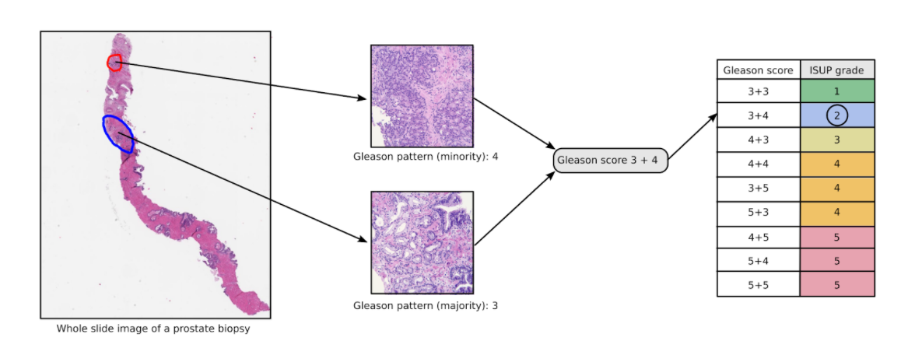

## Our approach

There are images with masks pointing out which part of the image should be search for cancer cells (important for Gleason scoring) and also those without masks. There is small difference in those sets sizes - some images lack masks. Which indicates that Gleason approach will have slightly less train samples (around 100).

We choose to make classfication based on ISUP ranking, since it's less time-consuming to train a network that way. Another thing is that we tried to projectile this 6-classes classification problem into regression with one number corresponding to (0,5) scale. We've proven experimentaly that classification works slightly better in this case.

Then, since prostate biopsies are mostly empty images, we decide to cut them into squares that include valuable information and then merge them in some potentially promising order. We tried to preprocess them before training, to minimize count of the same exact computations. Also we decided to compress images into `.png`, because it's not so heavy format compared with `.tiff`. Since it didn't speed up the process significantly, it was easier for us to work with orinal data format.

After normalizing preprocessed images, we put them in dataset, that we divide into 4 folds to process cross-validation. Our model is SE-ResNext50 network originally pretrained on ImageNet. We proceed training to adjust weights, having around 0.8 kappa score during that process.

#### Testing
Firstly, it was 64 per batch of `.png` images (64x64). Regression model with ADAM optimizer(learing rate = 1e-4) and Alphas scheduler factor = 0.5. Three epochs. QWK on cross-validation ~ 0.79. **Leaderboard QWK: 0.55**. After fixing some bug with the shape we made a large leap into **LB QWK: 0.72**

Secondly, since `.png` usage didn't speed up computation, we decided to go back to `.tiff`, cut and padded on-line. This time we did images in classification model with same parameters. Different fold concatenation. CValid QWK~0.75. **Leaderboard QWK: 0.74**

After that we tested our solution with different parameteres such as:
- batch and image size. 16 x 128 x 128, 64 x 64 x 64, 256 x 32 x 32. Option 64x64x64 works slightly better than the others.
- image padding and concatenation. We tried to merge little squares randomly, by the amount of valuable pixels and using heuristic that tried to put image pieces as closly to their original location as posibble. Third option performed the best.
- ADAM with different learing rates
- SGD parametrization (but since ADAM performed much better, we abandoned the SGD)
- Alpha scheduler's factor. Usually 0.25 was given best results.
- transformation parameters. Classical horizontal and vertical flips with random probability and previously calculated normalization inputs worked the best.

Later on we did regression on `.tiff` 64x64x64, ADAM(learning rate=1e-4). Factor=0.25 on 25 epochs. QWK on cross-validation ~ 0.83. **Leaderboard QWK: 0.78** (position 380 from about 650 participants at the submitting moment)

Several small chages led to QWK on cross-validation ~ 0.87 and **LB QWK: 0.77**. So our best submission was the one pointed out 4 lines above.

## Plans

If we were continuing work the first thing to improve is choosing more appropriate parameters (including number of epochs). We choose those ones that maximalize QWK on Cross-Validation, but despite that valid parts aren't overlapping the difference between CV and LB scores is huge. Maybe testing data have a little different distribution that training set (class distribution is different for both data providers). 

## What did we learn

We learned how to make a project from scratch to final results -  we had to deal with large data and we get to know how to reduce them keeping maximum information. We learned a lot about re-training a bigger net that those we used on assignments and how to choose parameters when full-training took about 20 hours (keeping in mind that our computing time was limited). Finally, we experienced that making an appropriate model is a really hard task, we spent long hours trying to find the best parameters, but our leaderboard position is unsatisfactory.

## Libraries and dependencies
- skiimage, PIL, imageio for files operation
- matplotlib, seaborn for visualization
- PyTorch for NN model

In [1]:
import os
import openslide
import skimage.io
from skimage.io import MultiImage
import random
import seaborn as sns
import imageio
import cv2
import zipfile
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
import torch
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display
from albumentations import Compose, Normalize, HorizontalFlip, VerticalFlip
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from zipfile import ZipFile
import torch.nn as nn
from sklearn.metrics import cohen_kappa_score
from collections import OrderedDict
import math
import scipy
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

In [2]:
main_path = '../input/prostate-cancer-grade-assessment'

train_images_path = f'{main_path}/train_images/'
train_masks_path = f'{main_path}/train_label_masks/'

test_images_path = f'{main_path}/test_images/'

img_ids = [name[:-5] for name in os.listdir(train_images_path)]

model_path = '../input/model-v1-2-classification/'

pretreined_model_path = '../input/se-resnext50-32x4d-pretrained/se_resnext50_32x4d-a260b3a4.pth'

In [3]:
train_df = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv')
test_df = pd.read_csv('../input/prostate-cancer-grade-assessment/test.csv')
train_df.head(10)

image_id data_provider  isup_grade gleason_score
0  0005f7aaab2800f6170c399693a96917    karolinska           0           0+0
1  000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0
2  0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4
3  001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4
4  001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0
5  002a4db09dad406c85505a00fb6f6144    karolinska           0           0+0
6  003046e27c8ead3e3db155780dc5498e    karolinska           1           3+3
7  0032bfa835ce0f43a92ae0bbab6871cb    karolinska           1           3+3
8  003a91841da04a5a31f808fb5c21538a    karolinska           1           3+3
9  003d4dd6bd61221ebc0bfb9350db333f    karolinska           1           3+3

In [4]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}%'.format(height / 100),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

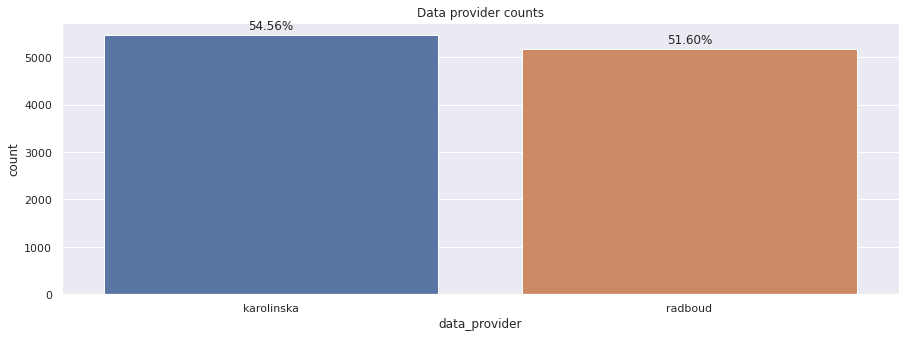

In [5]:
sns.set(style="darkgrid")
ax = sns.countplot(train_df['data_provider'])
ax.figure.set_size_inches(15, 5)
ax.set_title('Data provider counts')
autolabel(ax.patches)

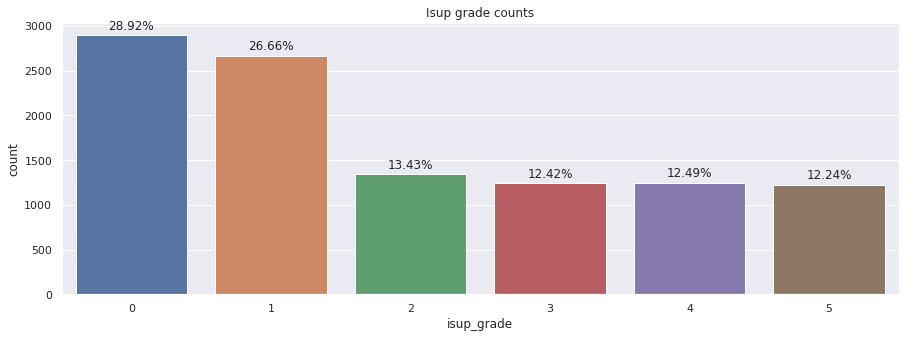

In [6]:
sns.set(style="darkgrid")
ax = sns.countplot(train_df['isup_grade'])
ax.figure.set_size_inches(15, 5)
ax.set_title('Isup grade counts')
autolabel(ax.patches)

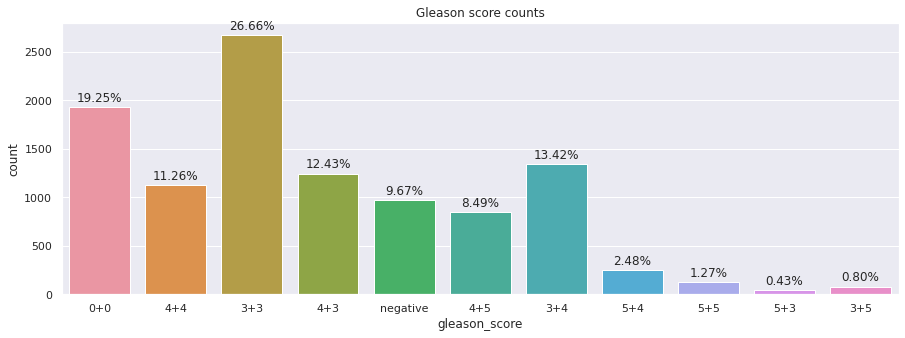

In [7]:
sns.set(style="darkgrid")
ax = sns.countplot(train_df['gleason_score'])
ax.figure.set_size_inches(15, 5)
ax.set_title('Gleason score counts')
autolabel(ax.patches)

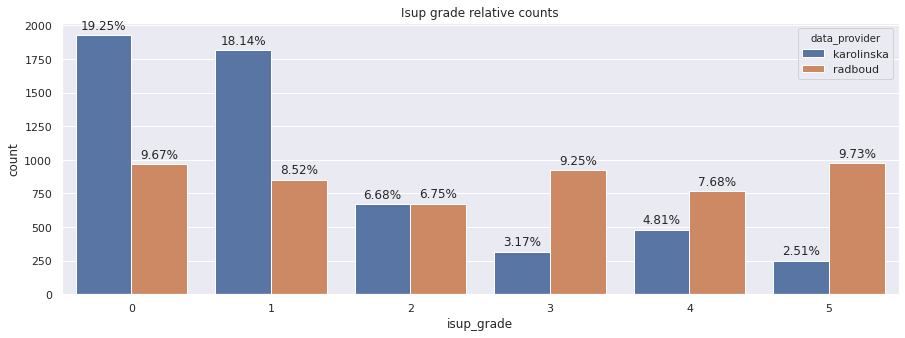

In [8]:
sns.set(style="darkgrid")
ax = sns.countplot(x = 'isup_grade', data = train_df, hue='data_provider')
ax.figure.set_size_inches(15, 5)
ax.set_title('Isup grade relative counts')
autolabel(ax.patches)

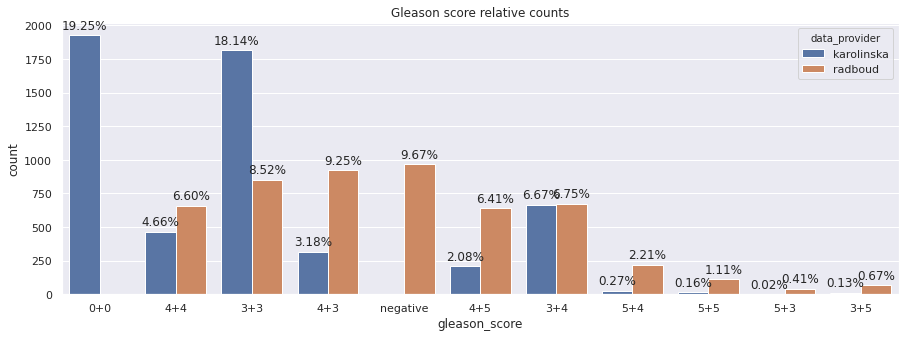

In [9]:
sns.set(style="darkgrid")
ax = sns.countplot(x = 'gleason_score', data = train_df, hue='data_provider')
ax.figure.set_size_inches(15, 5)
ax.set_title('Gleason score relative counts')
autolabel(ax.patches)

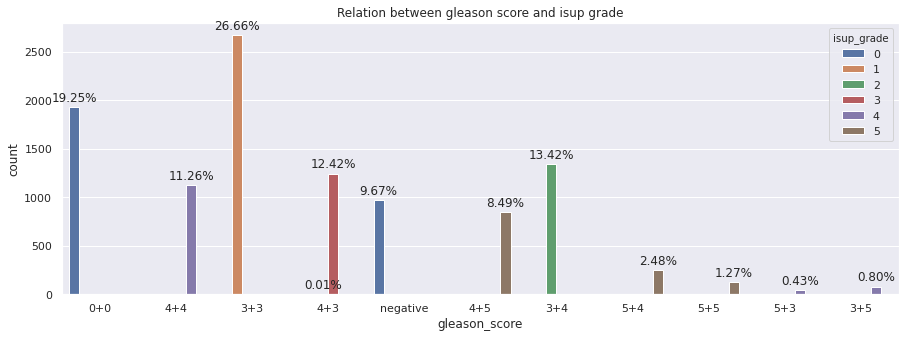

In [10]:
sns.set(style="darkgrid")
ax = sns.countplot(x = 'gleason_score', data = train_df, hue='isup_grade')
ax.figure.set_size_inches(15, 5)
ax.set_title('Relation between gleason score and isup grade')
autolabel(ax.patches)

In [11]:
N = 64
sz = 64

## Data preprocessing

In [12]:
def image_padding(img,val):
    '''
    This function takes an image and add a padding to the 
    image in the way to get shapes divisible by 64
    returns image
    '''
    shapex,shapey,_ = img.shape
    xpad = sz - shapex%sz
    ypad = sz - shapey%sz
    pad_width = ((xpad//2, xpad - xpad//2),(ypad//2, ypad - ypad//2), (0,0))
    img = np.pad(img, pad_width, constant_values = val)

    shapex,shapey,_ = img.shape
    xsquares,ysquares = shapex//sz, shapey//sz
    
    while xsquares * ysquares < N:
        pad_with = ((0,sz), (0,sz), (0,0))
        img = np.pad(img, pad_with, constant_values = val)
        shapex,shapey,_ = img.shape
        xsquares, ysquares = shapex//sz, shapey//sz
        
    return img

In [13]:
def get_tissue_squares(image,mask=None,res_idxs=None):
    '''
    This function takes a .tiff image and corresponding 
    mask and returns N 64x64 squared images based on 
    the amount of the tissue inside squares
    returns image or image with mask
    '''
    
    squares = {}
    masks = {}
    
    image = image_padding(image, 255)
    if mask is not None:
        mask = image_padding(mask, 0)
        assert mask.shape == image.shape
    
    shapex, shapey, _ = image.shape
    xsquares, ysquares = shapex//sz, shapey//sz
    
    image = image.reshape(xsquares, sz, ysquares, sz, 3)
    image = image.transpose(0,2,1,3,4).reshape(-1, sz, sz, 3)
    
    if mask is not None:
        mask = mask.reshape(xsquares,sz,ysquares,sz,3)\
                   .transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    
    # idxs of squares with the most tissue
    idxs = np.argsort(image.reshape(image.shape[0],-1).sum(-1))[:N]
    
    assert len(idxs) == N
    
    def gen_res_idxs():
        st = ( (int(N**0.5)-1)//2, (int(N**0.5)-1)//2 )
        res = [st]
        sign = 1

        for e in range(1,N):
            for i in range(e):
                x,y = st
                st = (x,y+1*sign)
                res.append(st)

            for i in range(e):
                x,y = st
                st = (x+1*sign,y)
                res.append(st)

            sign *= -1

            if (len(res)>N):
                break

        return [x*int(N**0.5)+y for x,y in res[:N]]

    if res_idxs is None:
        res_idxs = gen_res_idxs()
        
    in_res_idxs = set()
    
    def add_elem(i,idx=-1):
        '''
        Inner function
        adds new square to the result
        '''
        vectrs = [(-1,0),(1,0),(0,-1),(0,1)]
        if i in squares or i<0 or i>N:
            return
    
        if idx == -1:
            for idx in idxs:
                if idx not in in_res_idxs:
                    break
                
        squares[i] = image[idx]
        if mask is not None:
            masks[i] = mask[idx]
        in_res_idxs.add(idx)
        
        org_x,org_y = idx//ysquares, idx%ysquares
        x, y = i//int(N**0.5), i%int(N**0.5)
        
        for dx,dy in vectrs:
            nx, ny = org_x+dx, org_y+dy
            if nx*ysquares+ny in idxs and nx*ysquares+ny not in in_res_idxs:
                add_elem( (x+dx)*int(N**0.5)+y+dy, nx*ysquares+ny )
    
    
    for ridx in res_idxs:
        add_elem(ridx)
    
    assert list(sorted(idxs)) == list(sorted(in_res_idxs))
    
    squares = np.array([squares[i] for i in range(N)])
    if mask is not None:
        masks = np.array([masks[i] for i in range(N)])
        return squares,masks
    else:
        return squares

In [14]:
def concat_squares(img_s,mask_s=None):
    '''
    this function takes image squares from 
    "get tissue squares" function and concatenates 
    them to get the whole image
    '''

    img_rows = []
    for i in range(0,N,int(N**0.5)):
        img_rows.append(cv2.hconcat(img_s[i:i+int(N**0.5),:,:]))
    
    image=cv2.vconcat(img_rows)

    
    if mask_s is None:
        return image
    
    mask_rows = []
    
    for i in range(0,N,int(N**0.5)):
        mask_rows.append(cv2.hconcat(mask_s[i:i+int(N**0.5),:,:]))
    
    mask=cv2.vconcat(mask_rows)
    
    return image,mask

In [15]:
def print_image(img,mask=None,title = ""):
    '''
    this function prints out image in RGB
    works also with masks when included
    '''
    if mask is None:
        plt.figure(figsize = (7,7))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        return
    
    cmap = matplotlib.colors.ListedColormap(['white', 'gray', 'green', 'yellow', 'orange', 'red'])
    
    f,axs = plt.subplots(1,2,figsize=(30,15))
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[1].imshow(mask[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
    axs[1].axis('off')
    if title != '':
        f.suptitle(title, fontsize=16)
    plt.show()

In [16]:
def print_n_image(imgs,masks,n,title=''):
    '''
    this function prints out image in RGB
    works also with masks when included
    '''
    
    cmap = matplotlib.colors.ListedColormap(['white', 'gray', 'green', 'yellow', 'orange', 'red'])
    
    f,axs = plt.subplots(n,2,figsize=(30,n*15))
    for i in range(n):
        axs[i][0].imshow(imgs[i])
        axs[i][0].axis('off')
        axs[i][1].imshow(masks[i][:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
        axs[i][1].axis('off')
    if title != '':
        f.suptitle(title, fontsize=16)
    plt.show()

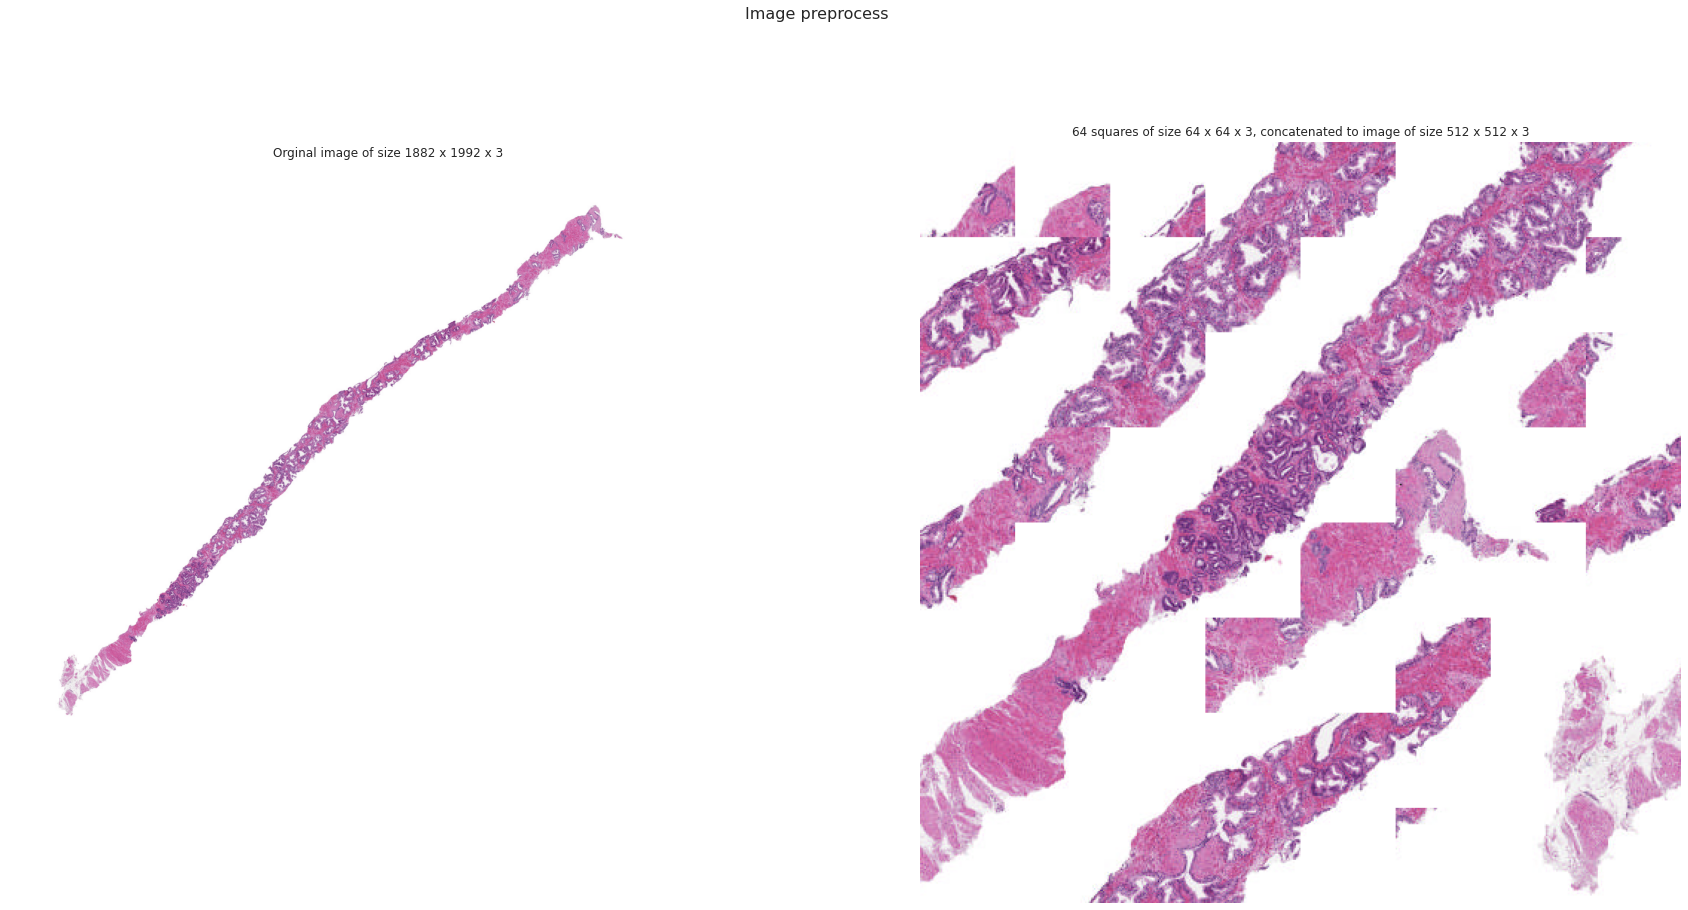

In [17]:
img_id = '004391d48d58b18156f811087cd38abf'
org_img = MultiImage(train_images_path+img_id+'.tiff')[-1]
w,h,c = org_img.shape
image_s = get_tissue_squares(org_img)
image = concat_squares(image_s)
f,axs = plt.subplots(1,2,figsize=(30,15))
axs[0].imshow(org_img)
axs[0].axis('off')
axs[0].set_title(f'Orginal image of size {w} x {h} x {c}')
axs[1].imshow(image)
axs[1].axis('off')
axs[1].set_title(f'{N} squares of size {sz} x {sz} x 3, concatenated to image of size 512 x 512 x 3')
f.suptitle('Image preprocess', fontsize=16)
plt.show()

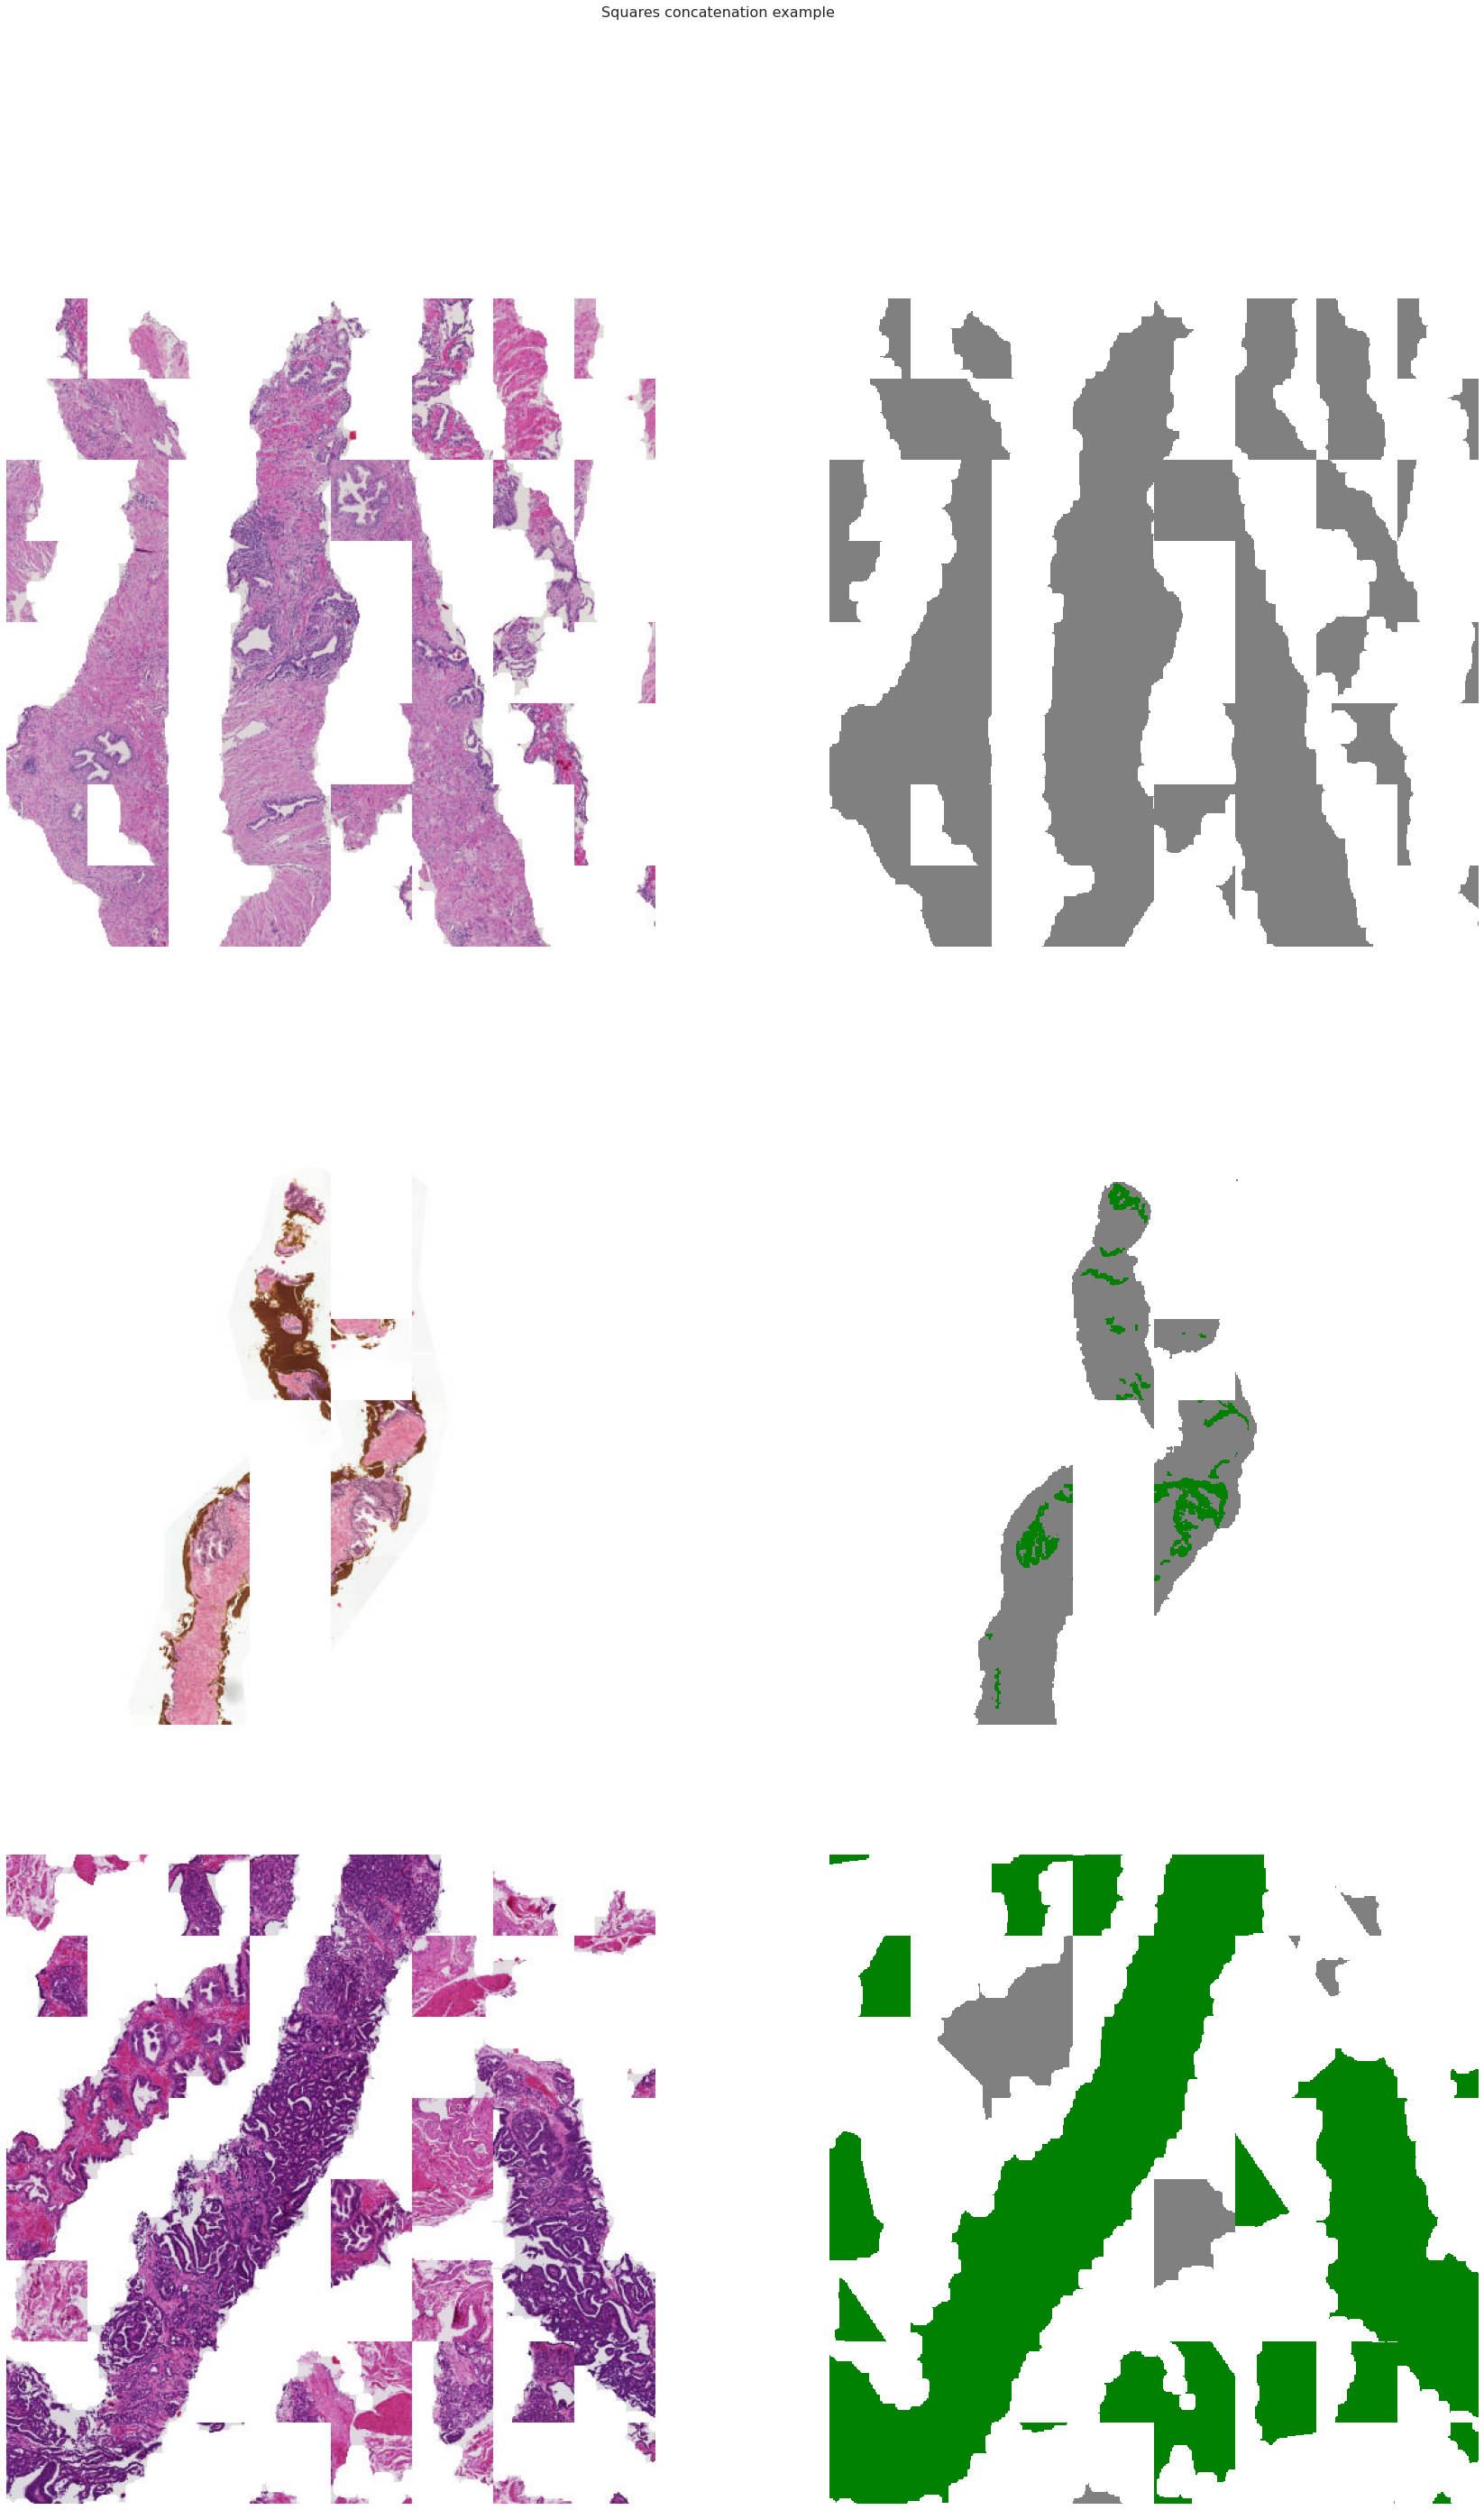

In [18]:
n = 3
img_ids = img_ids[:n]
imgs,masks=[],[]
for i in range(n):
    img_id = img_ids[i]
    img = MultiImage(train_images_path+img_id+'.tiff')[-1]
    mask = MultiImage(train_masks_path+img_id+'_mask.tiff')[-1]
    image_s,mask_s = get_tissue_squares(img,mask)
    image,mask = concat_squares(image_s,mask_s)
    imgs.append(image)
    masks.append(mask)
print_n_image(imgs,masks,n,'Squares concatenation example')

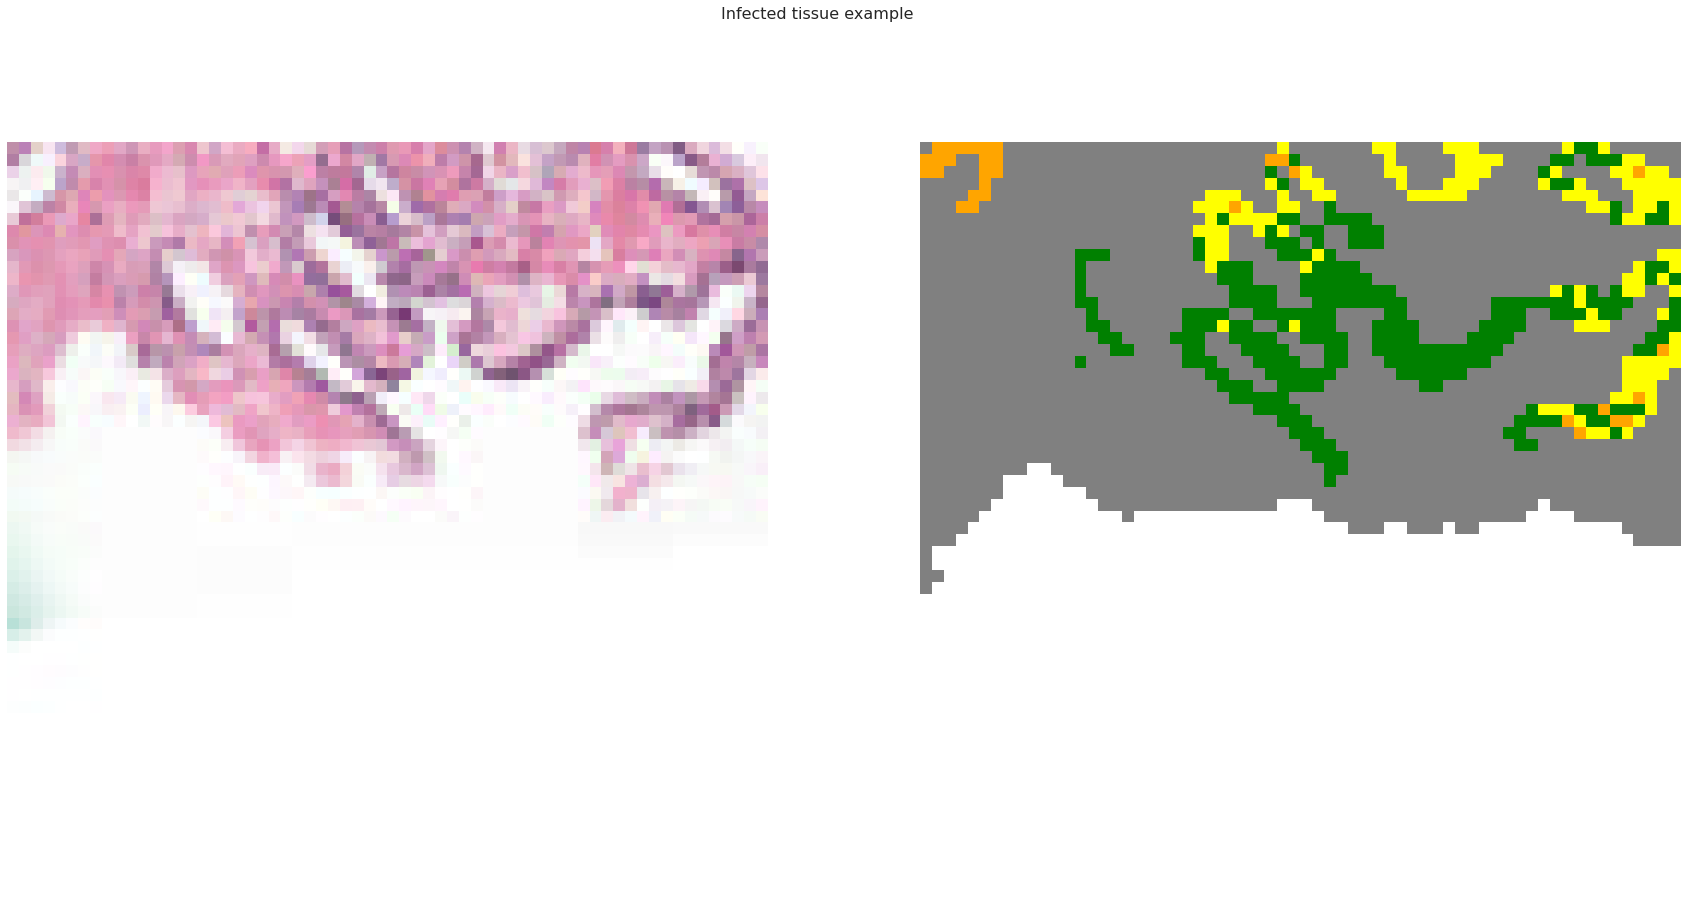

In [19]:
img_id = 'fcf3ef06a3601448061b7b1adda97b89'
img = MultiImage(train_images_path+img_id+'.tiff')[-1]
mask = MultiImage(train_masks_path+img_id+'_mask.tiff')[-1]

image_s,mask_s = get_tissue_squares(img,mask)
image,mask = concat_squares(image_s,mask_s)
i = 8
cmap = matplotlib.colors.ListedColormap(['white', 'gray', 'green', 'yellow', 'orange', 'red'])
f,axs = plt.subplots(1,2,figsize=(30,15))
axs[0].imshow(image_s[i])
axs[0].axis('off')
axs[1].imshow(mask_s[i][:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5)
axs[1].axis('off')
f.suptitle('Infected tissue example', fontsize=16)
plt.show()

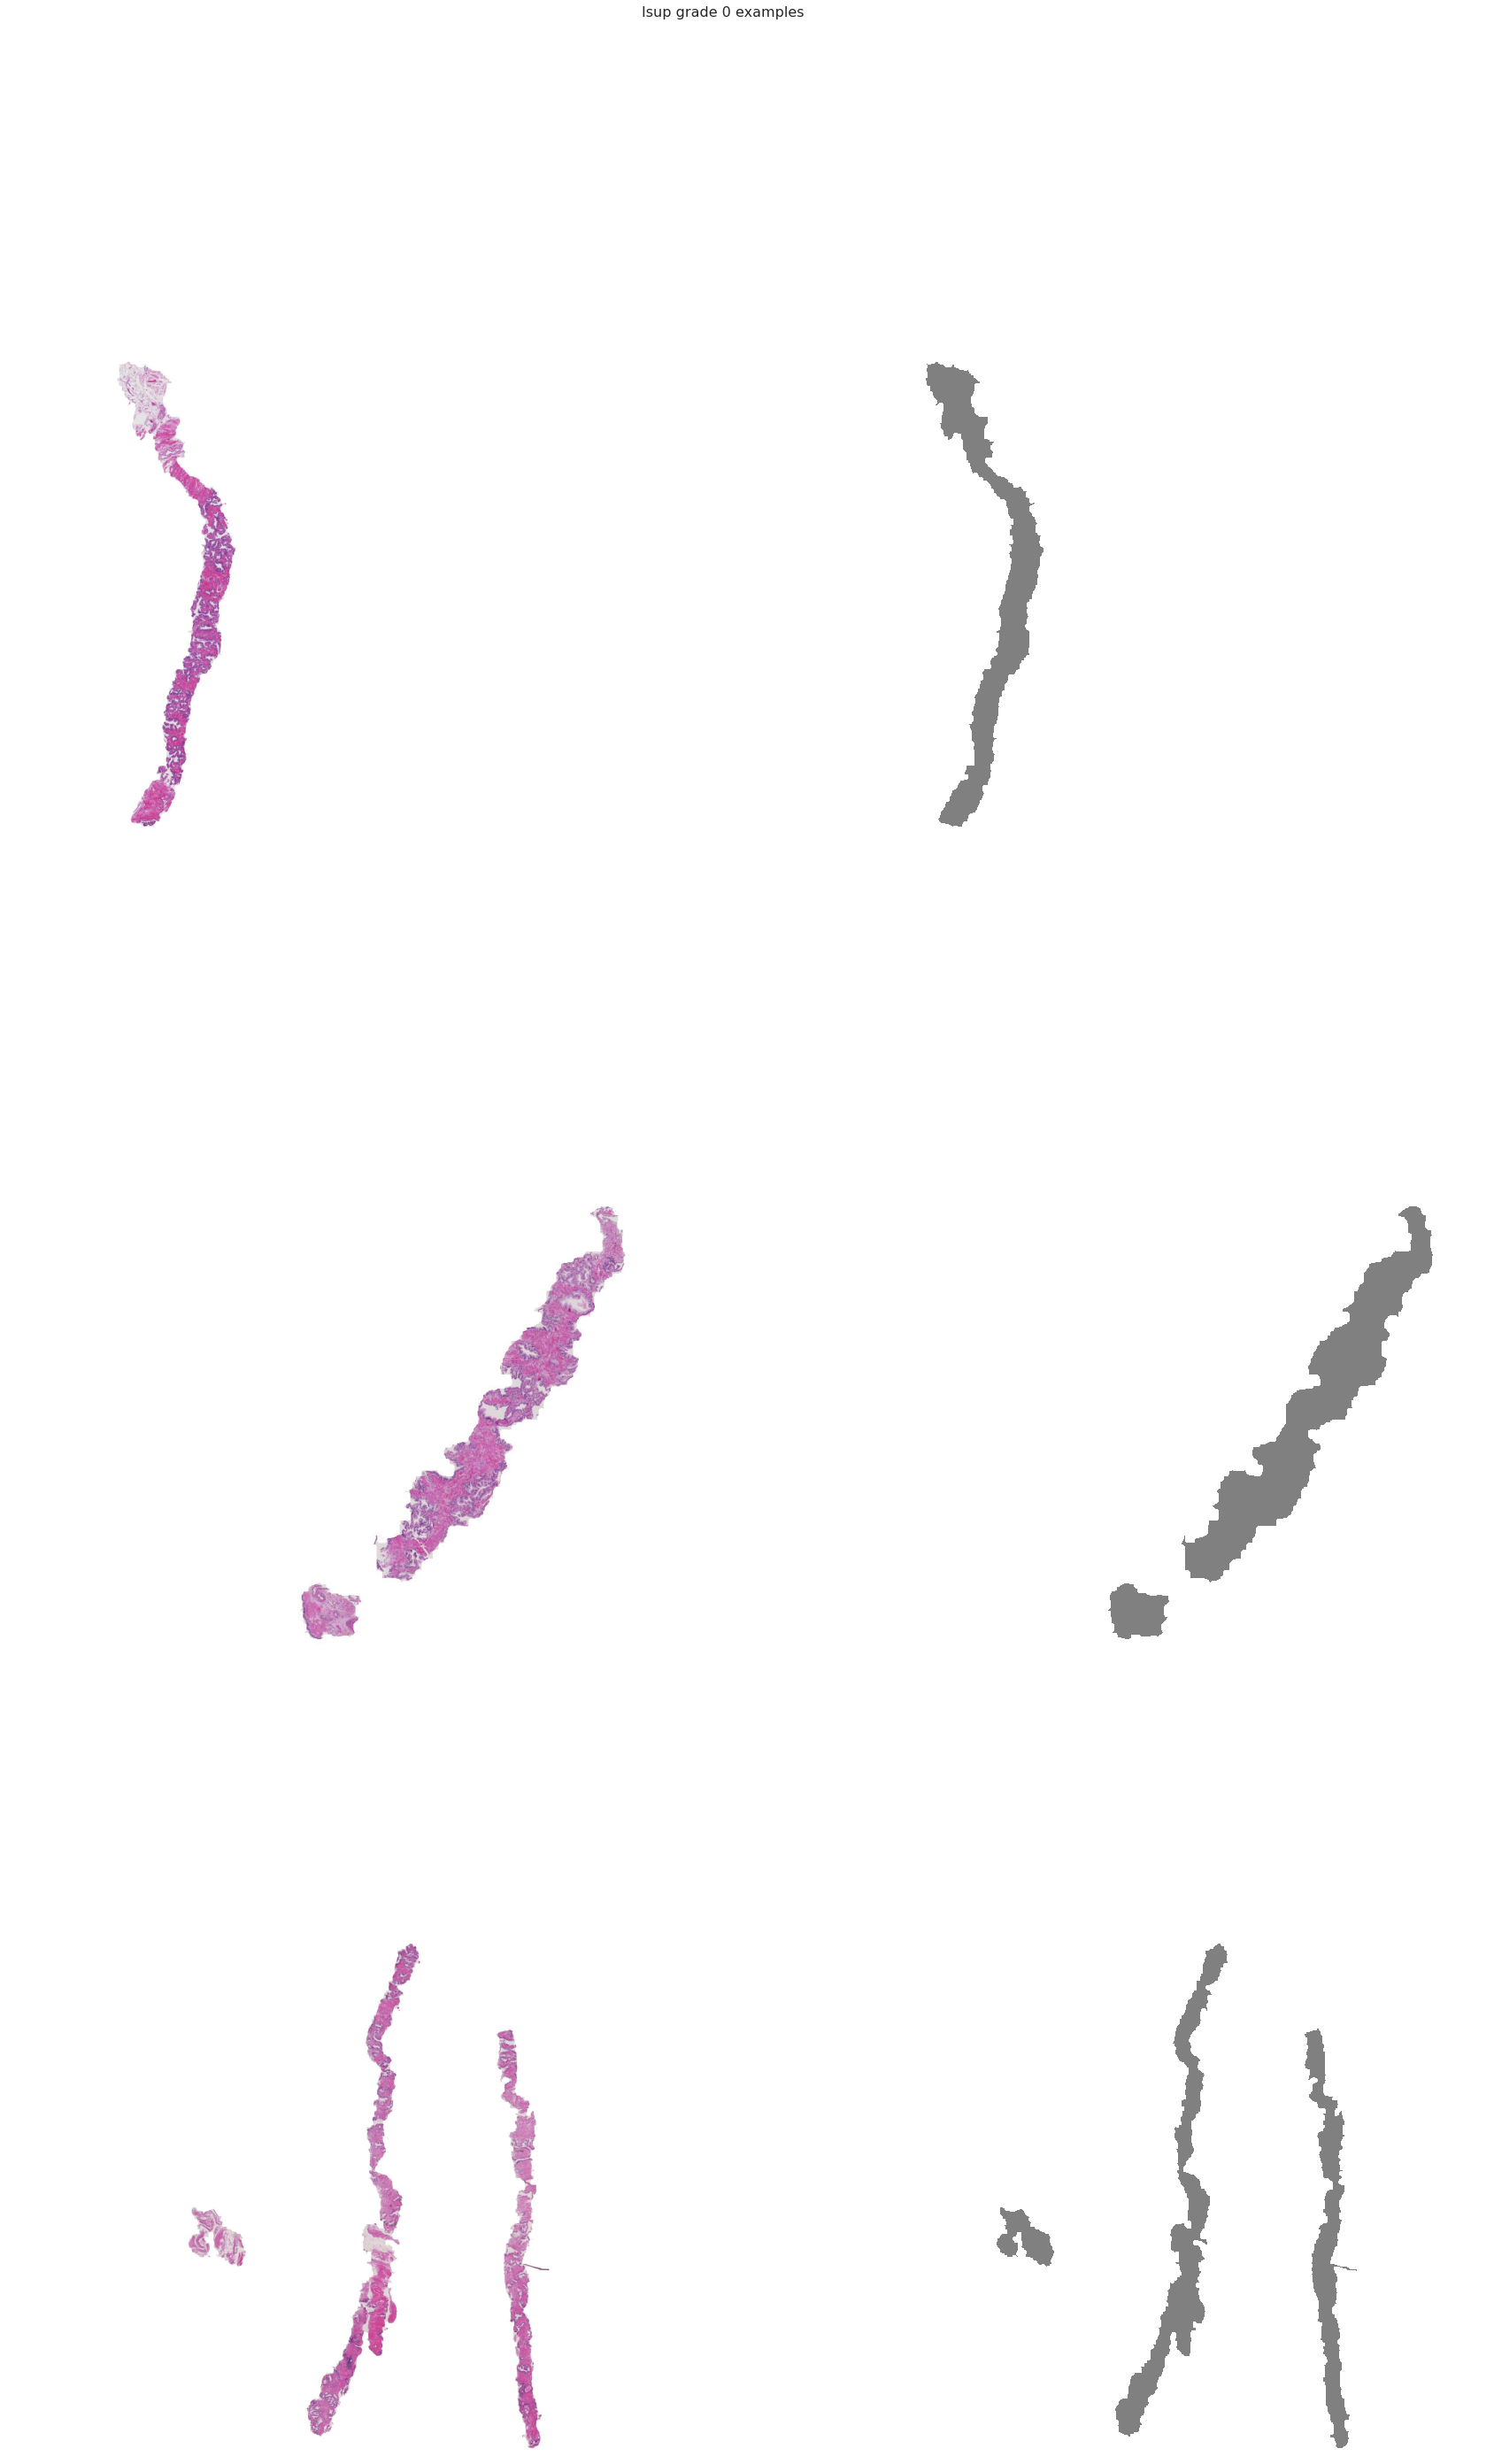

In [20]:
n = 3
isup_grade = 0
img_ids = list(train_df[train_df['isup_grade']==isup_grade]['image_id'])[:n]
imgs = [MultiImage(train_images_path+img_id+'.tiff')[-1] for img_id in img_ids]
masks = [MultiImage(train_masks_path+img_id+'_mask.tiff')[-1] for img_id in img_ids]
print_n_image(imgs,masks,n,f'Isup grade {isup_grade} examples')

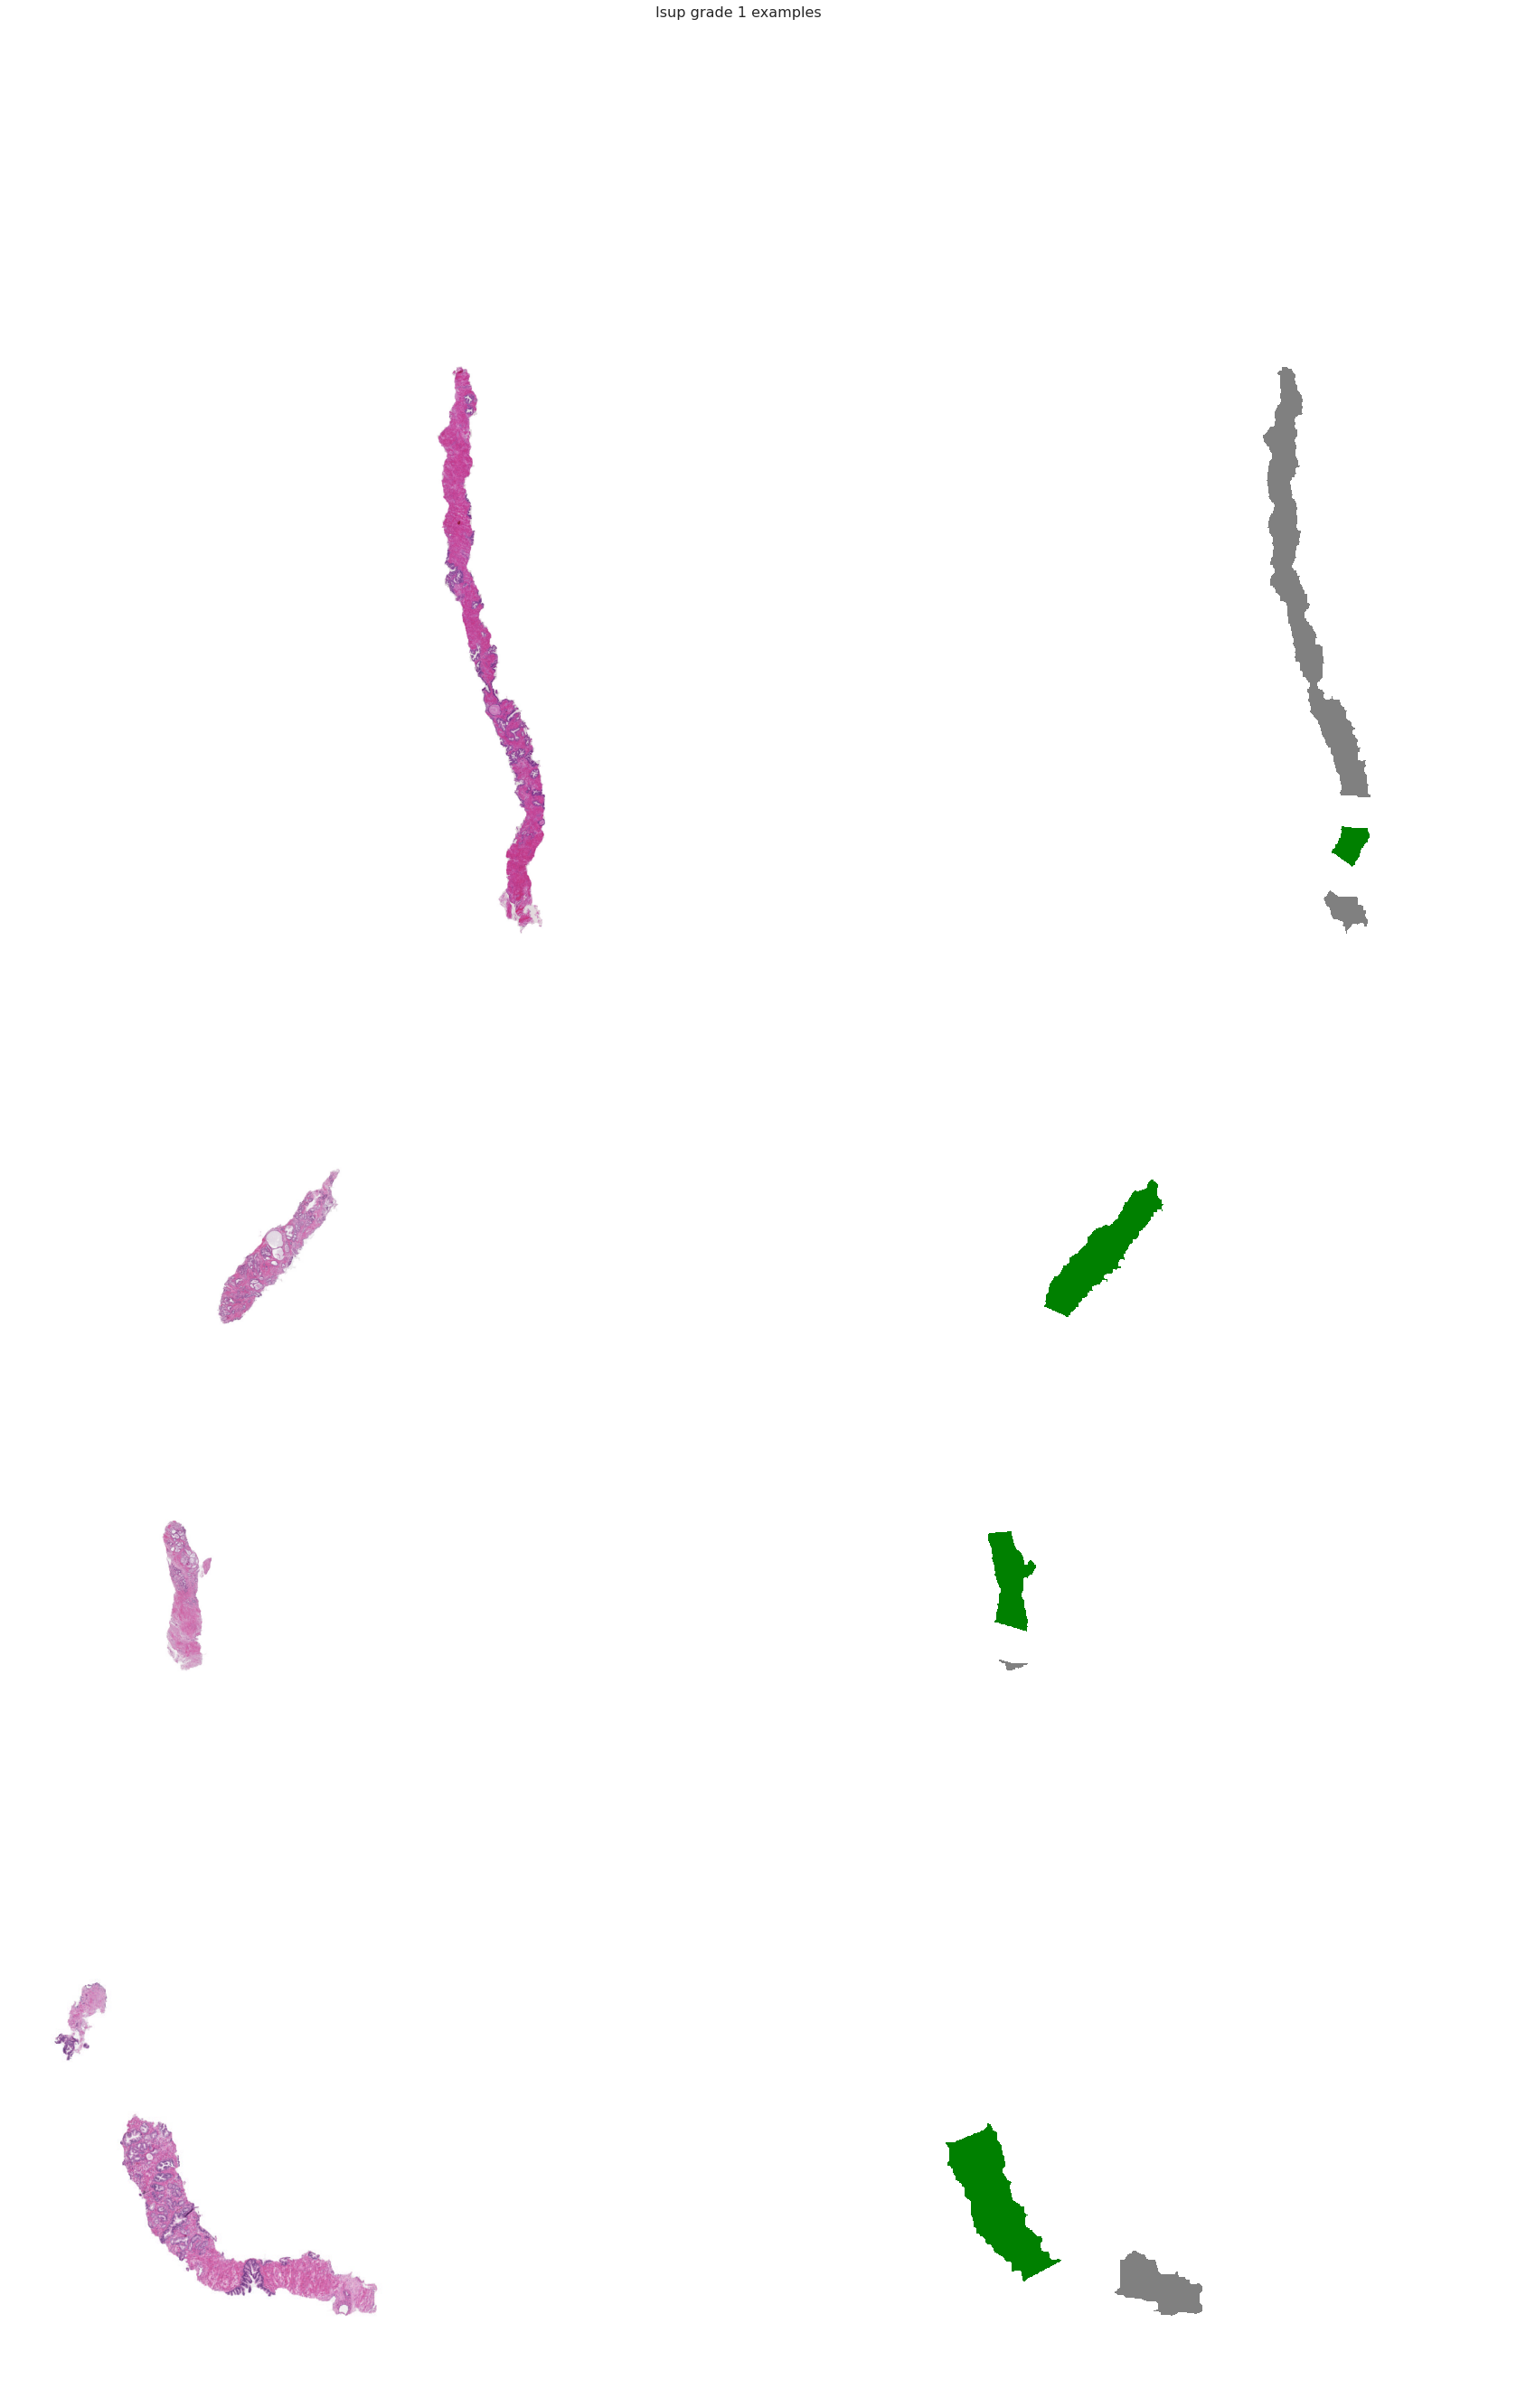

In [21]:
n = 3
isup_grade = 1
img_ids = list(train_df[train_df['isup_grade']==isup_grade]['image_id'])[:n]
imgs = [MultiImage(train_images_path+img_id+'.tiff')[-1] for img_id in img_ids]
masks = [MultiImage(train_masks_path+img_id+'_mask.tiff')[-1] for img_id in img_ids]
print_n_image(imgs,masks,n,f'Isup grade {isup_grade} examples')

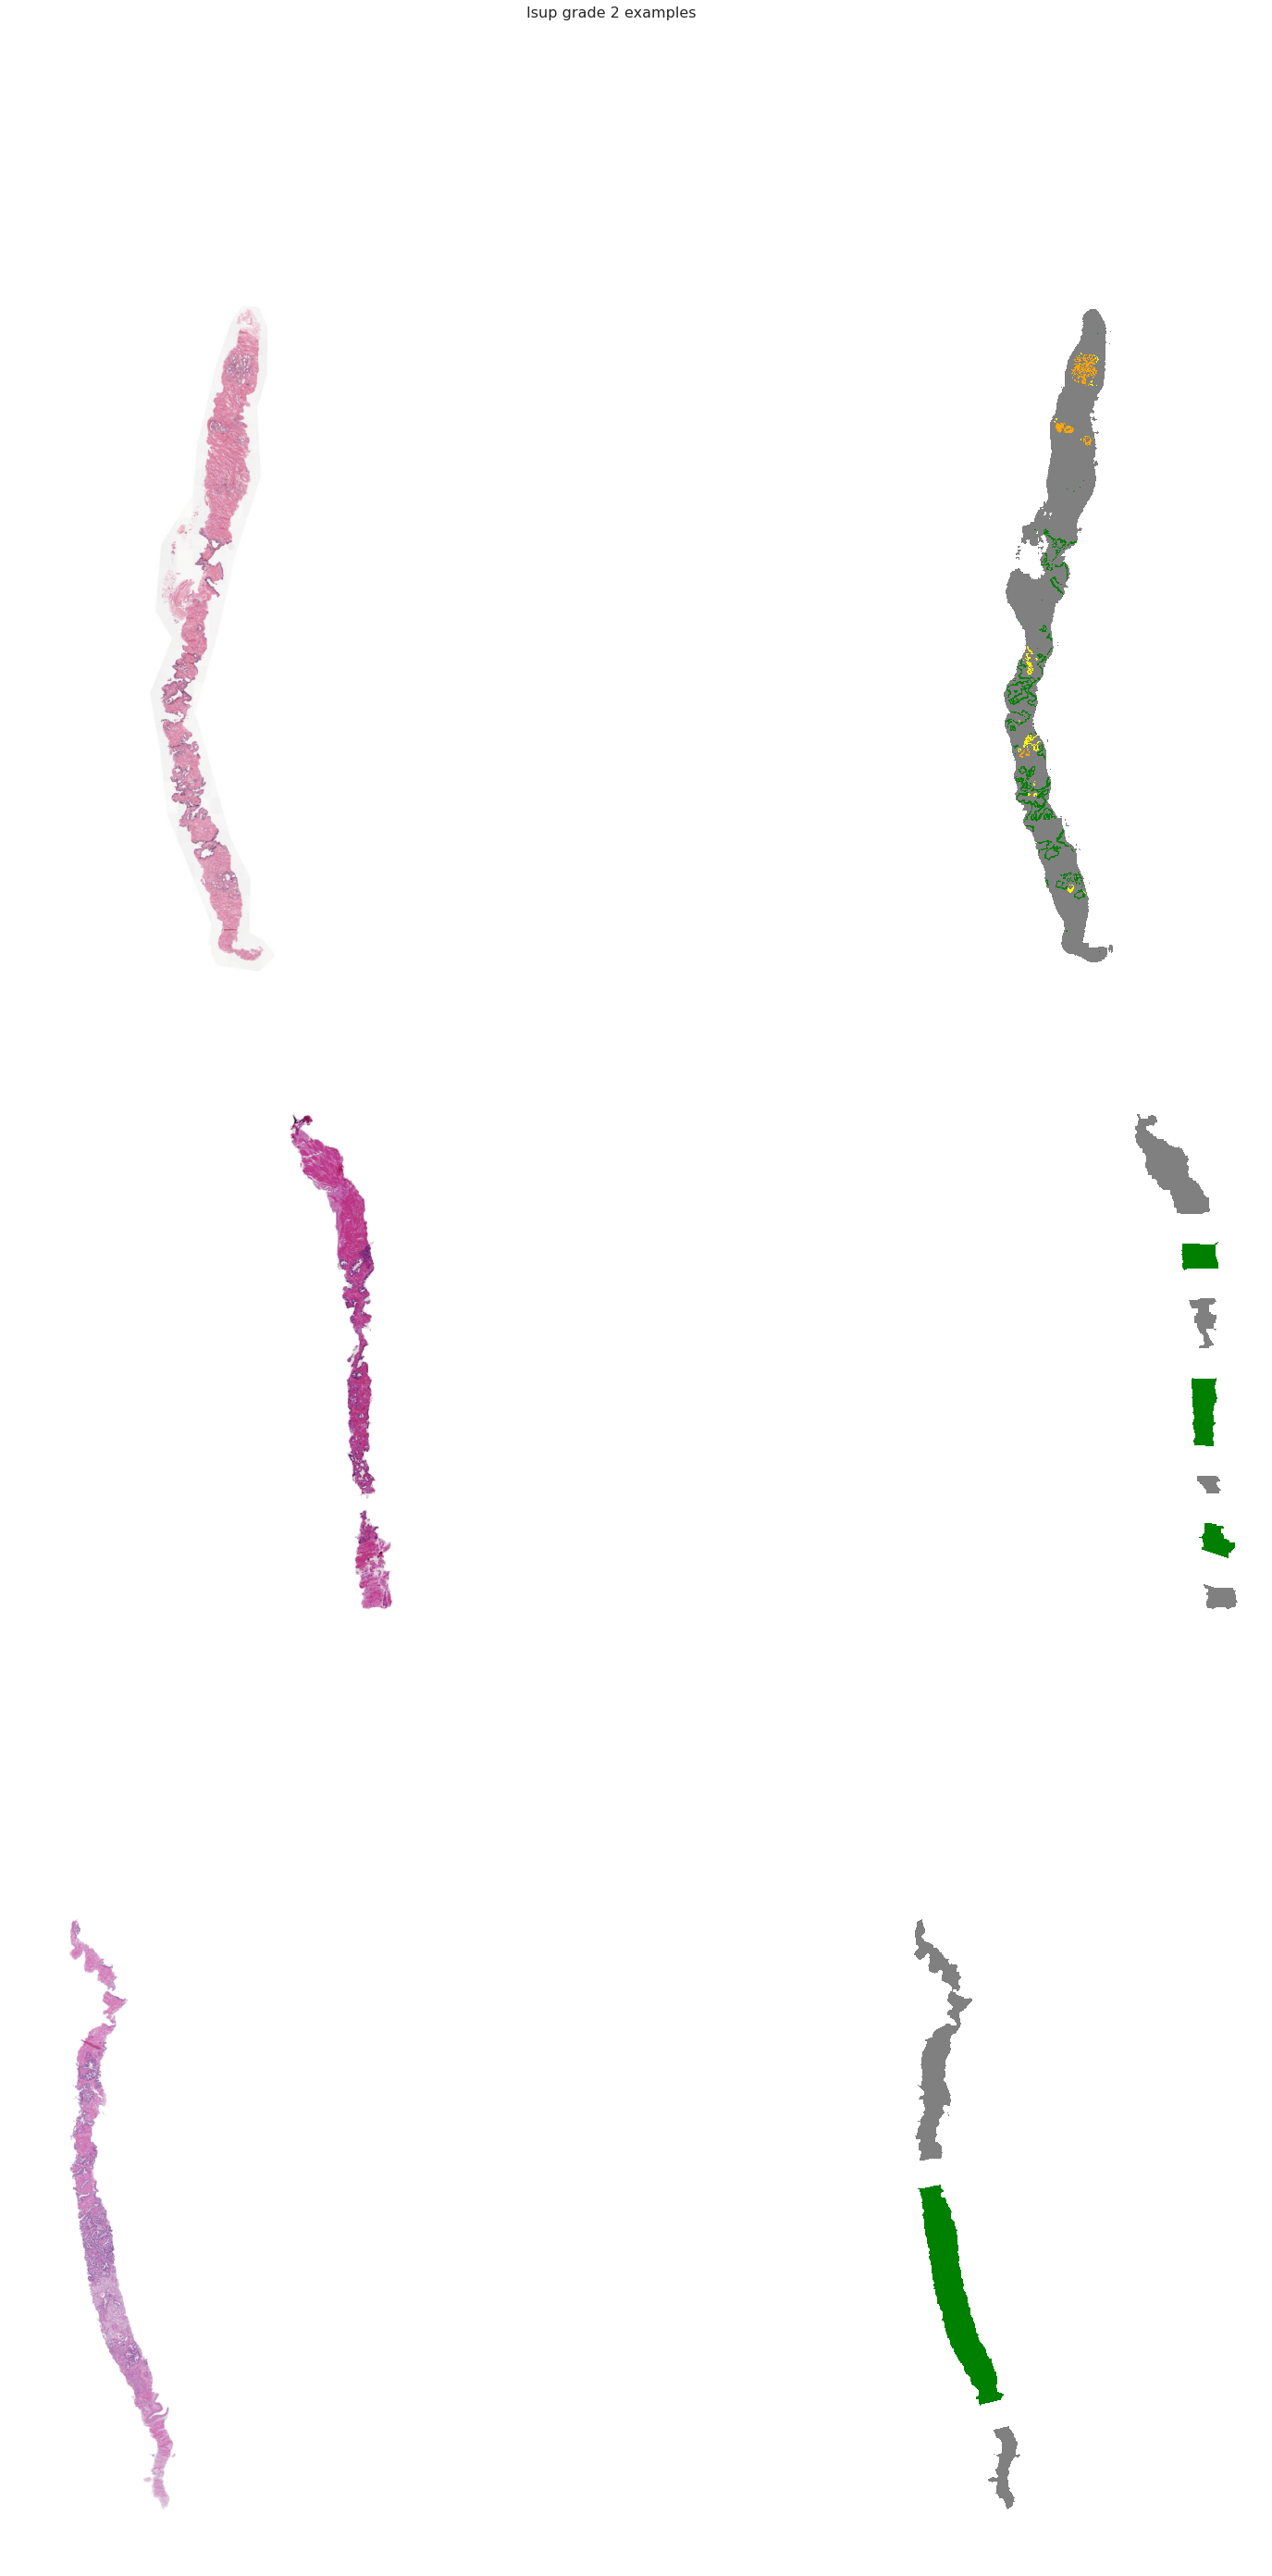

In [22]:
n = 3
isup_grade = 2
img_ids = list(train_df[train_df['isup_grade']==isup_grade]['image_id'])[:n]
imgs = [MultiImage(train_images_path+img_id+'.tiff')[-1] for img_id in img_ids]
masks = [MultiImage(train_masks_path+img_id+'_mask.tiff')[-1] for img_id in img_ids]
print_n_image(imgs,masks,n,f'Isup grade {isup_grade} examples')

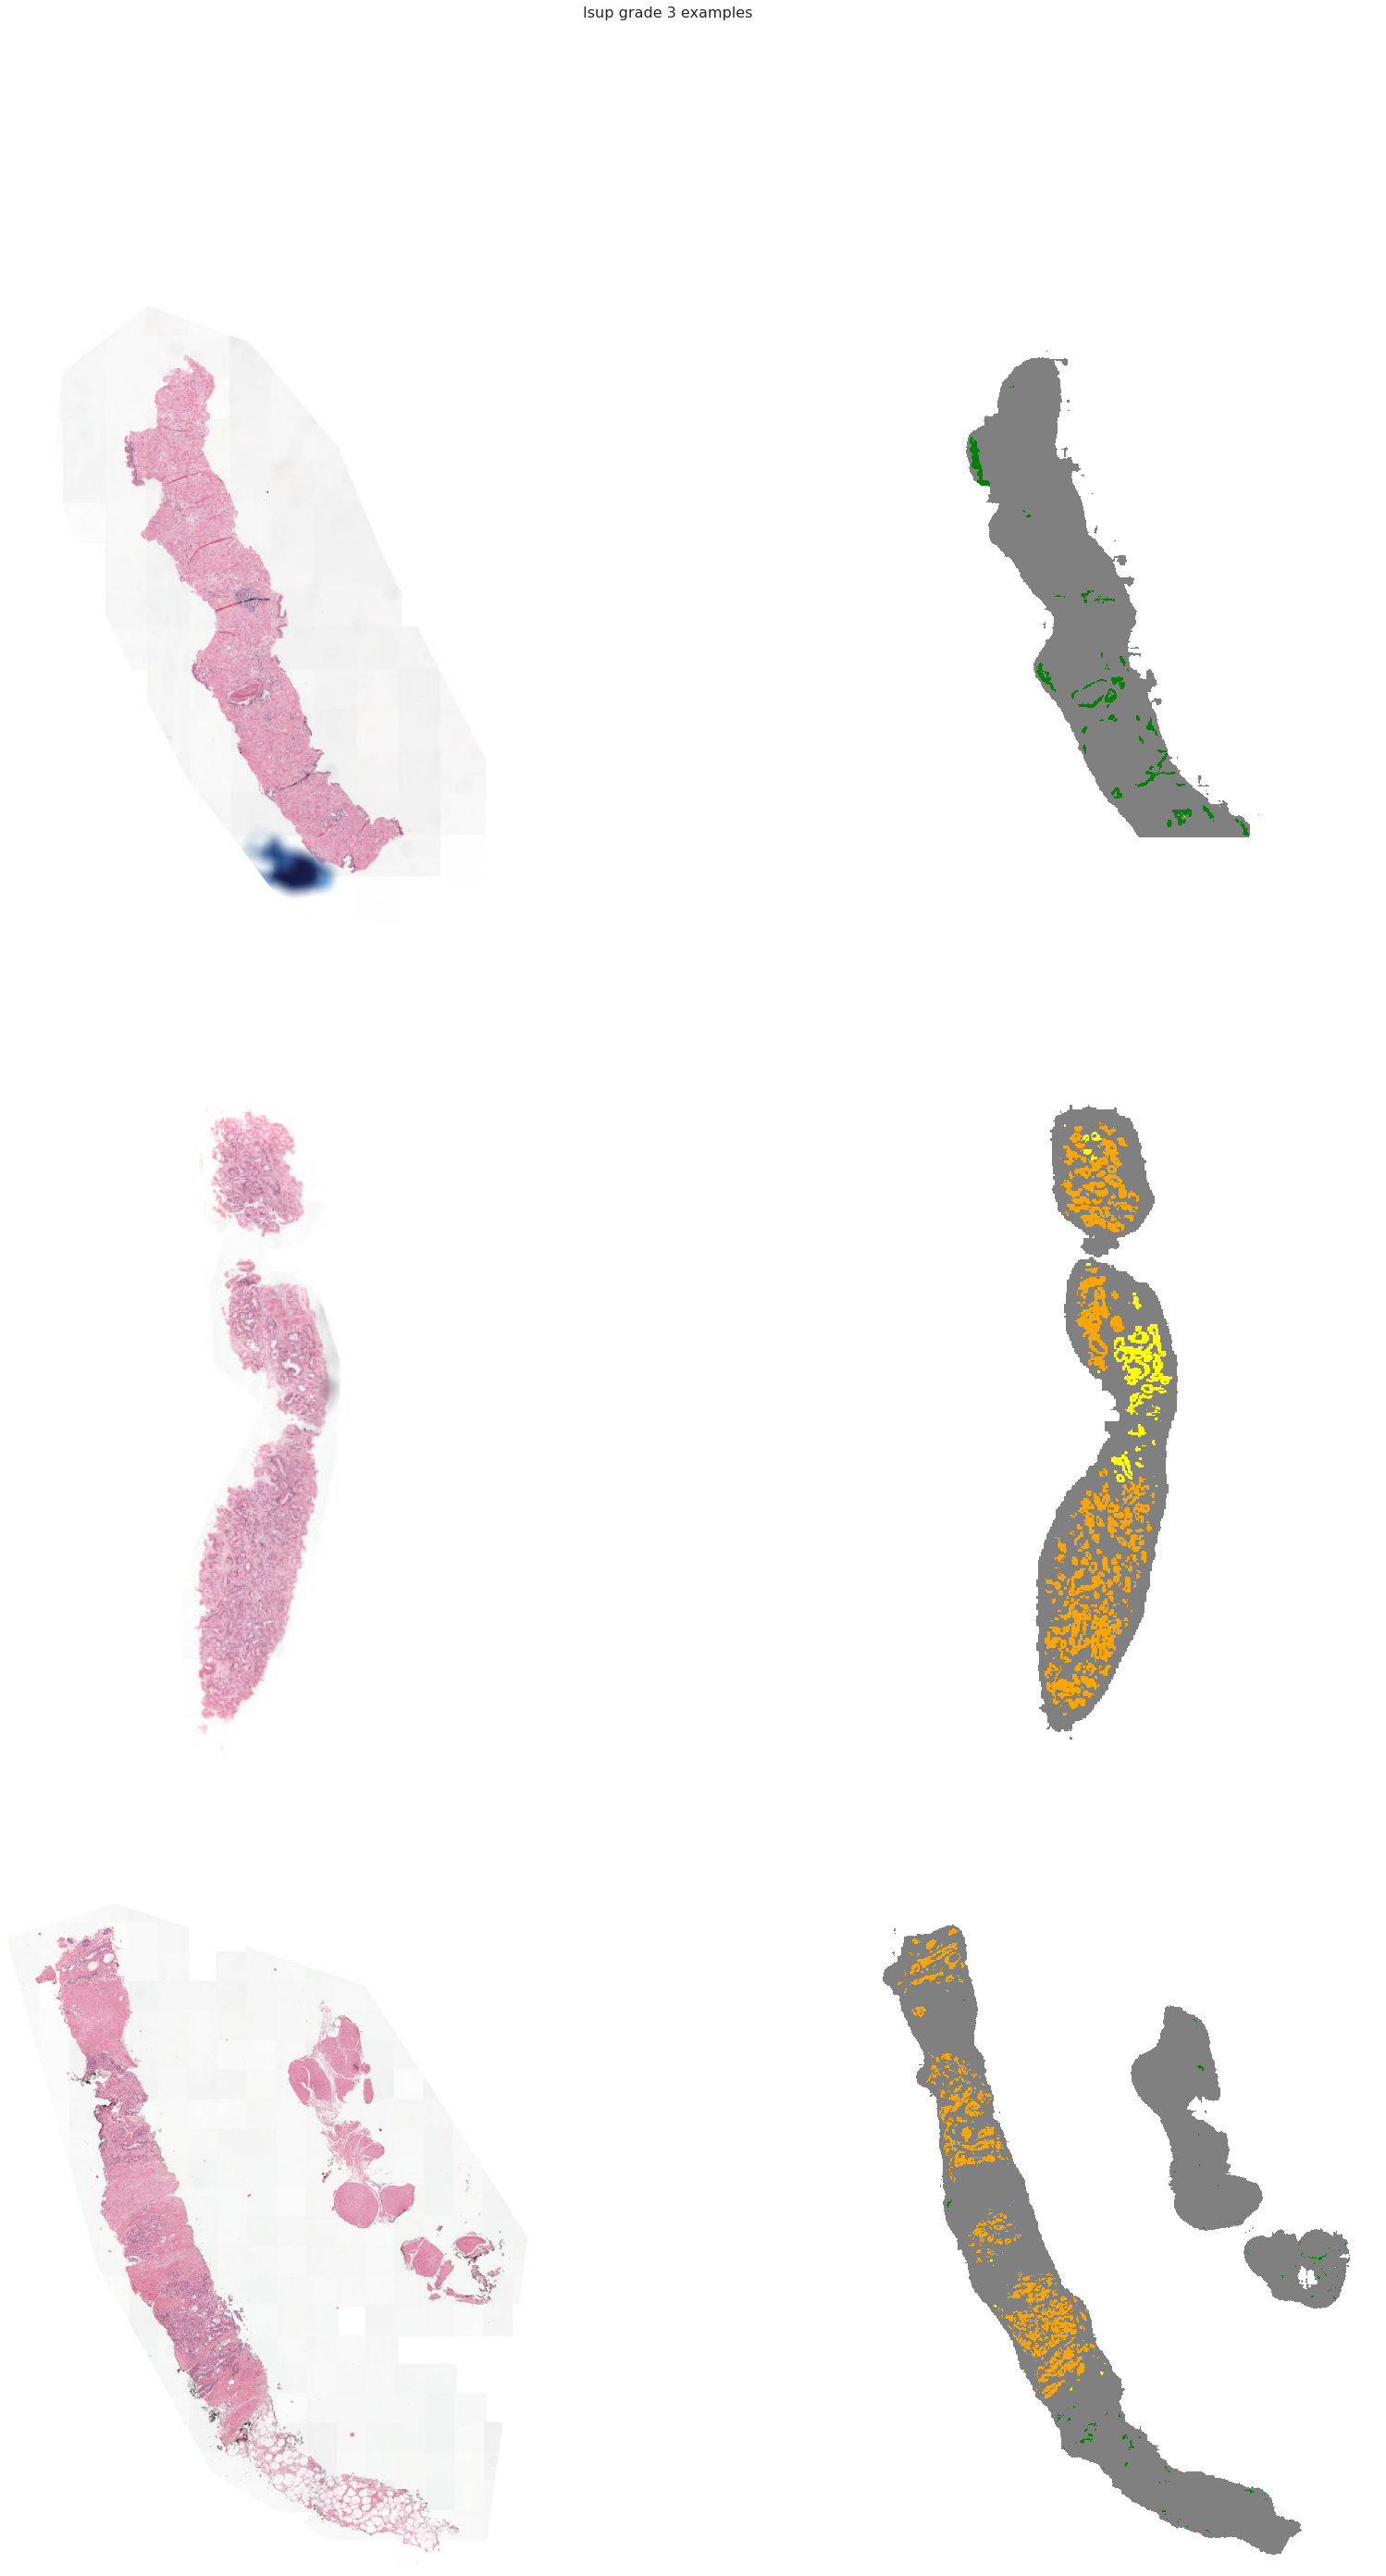

In [23]:
n = 3
isup_grade = 3
img_ids = list(train_df[train_df['isup_grade']==isup_grade]['image_id'])[:n]
imgs = [MultiImage(train_images_path+img_id+'.tiff')[-1] for img_id in img_ids]
masks = [MultiImage(train_masks_path+img_id+'_mask.tiff')[-1] for img_id in img_ids]
print_n_image(imgs,masks,n,f'Isup grade {isup_grade} examples')

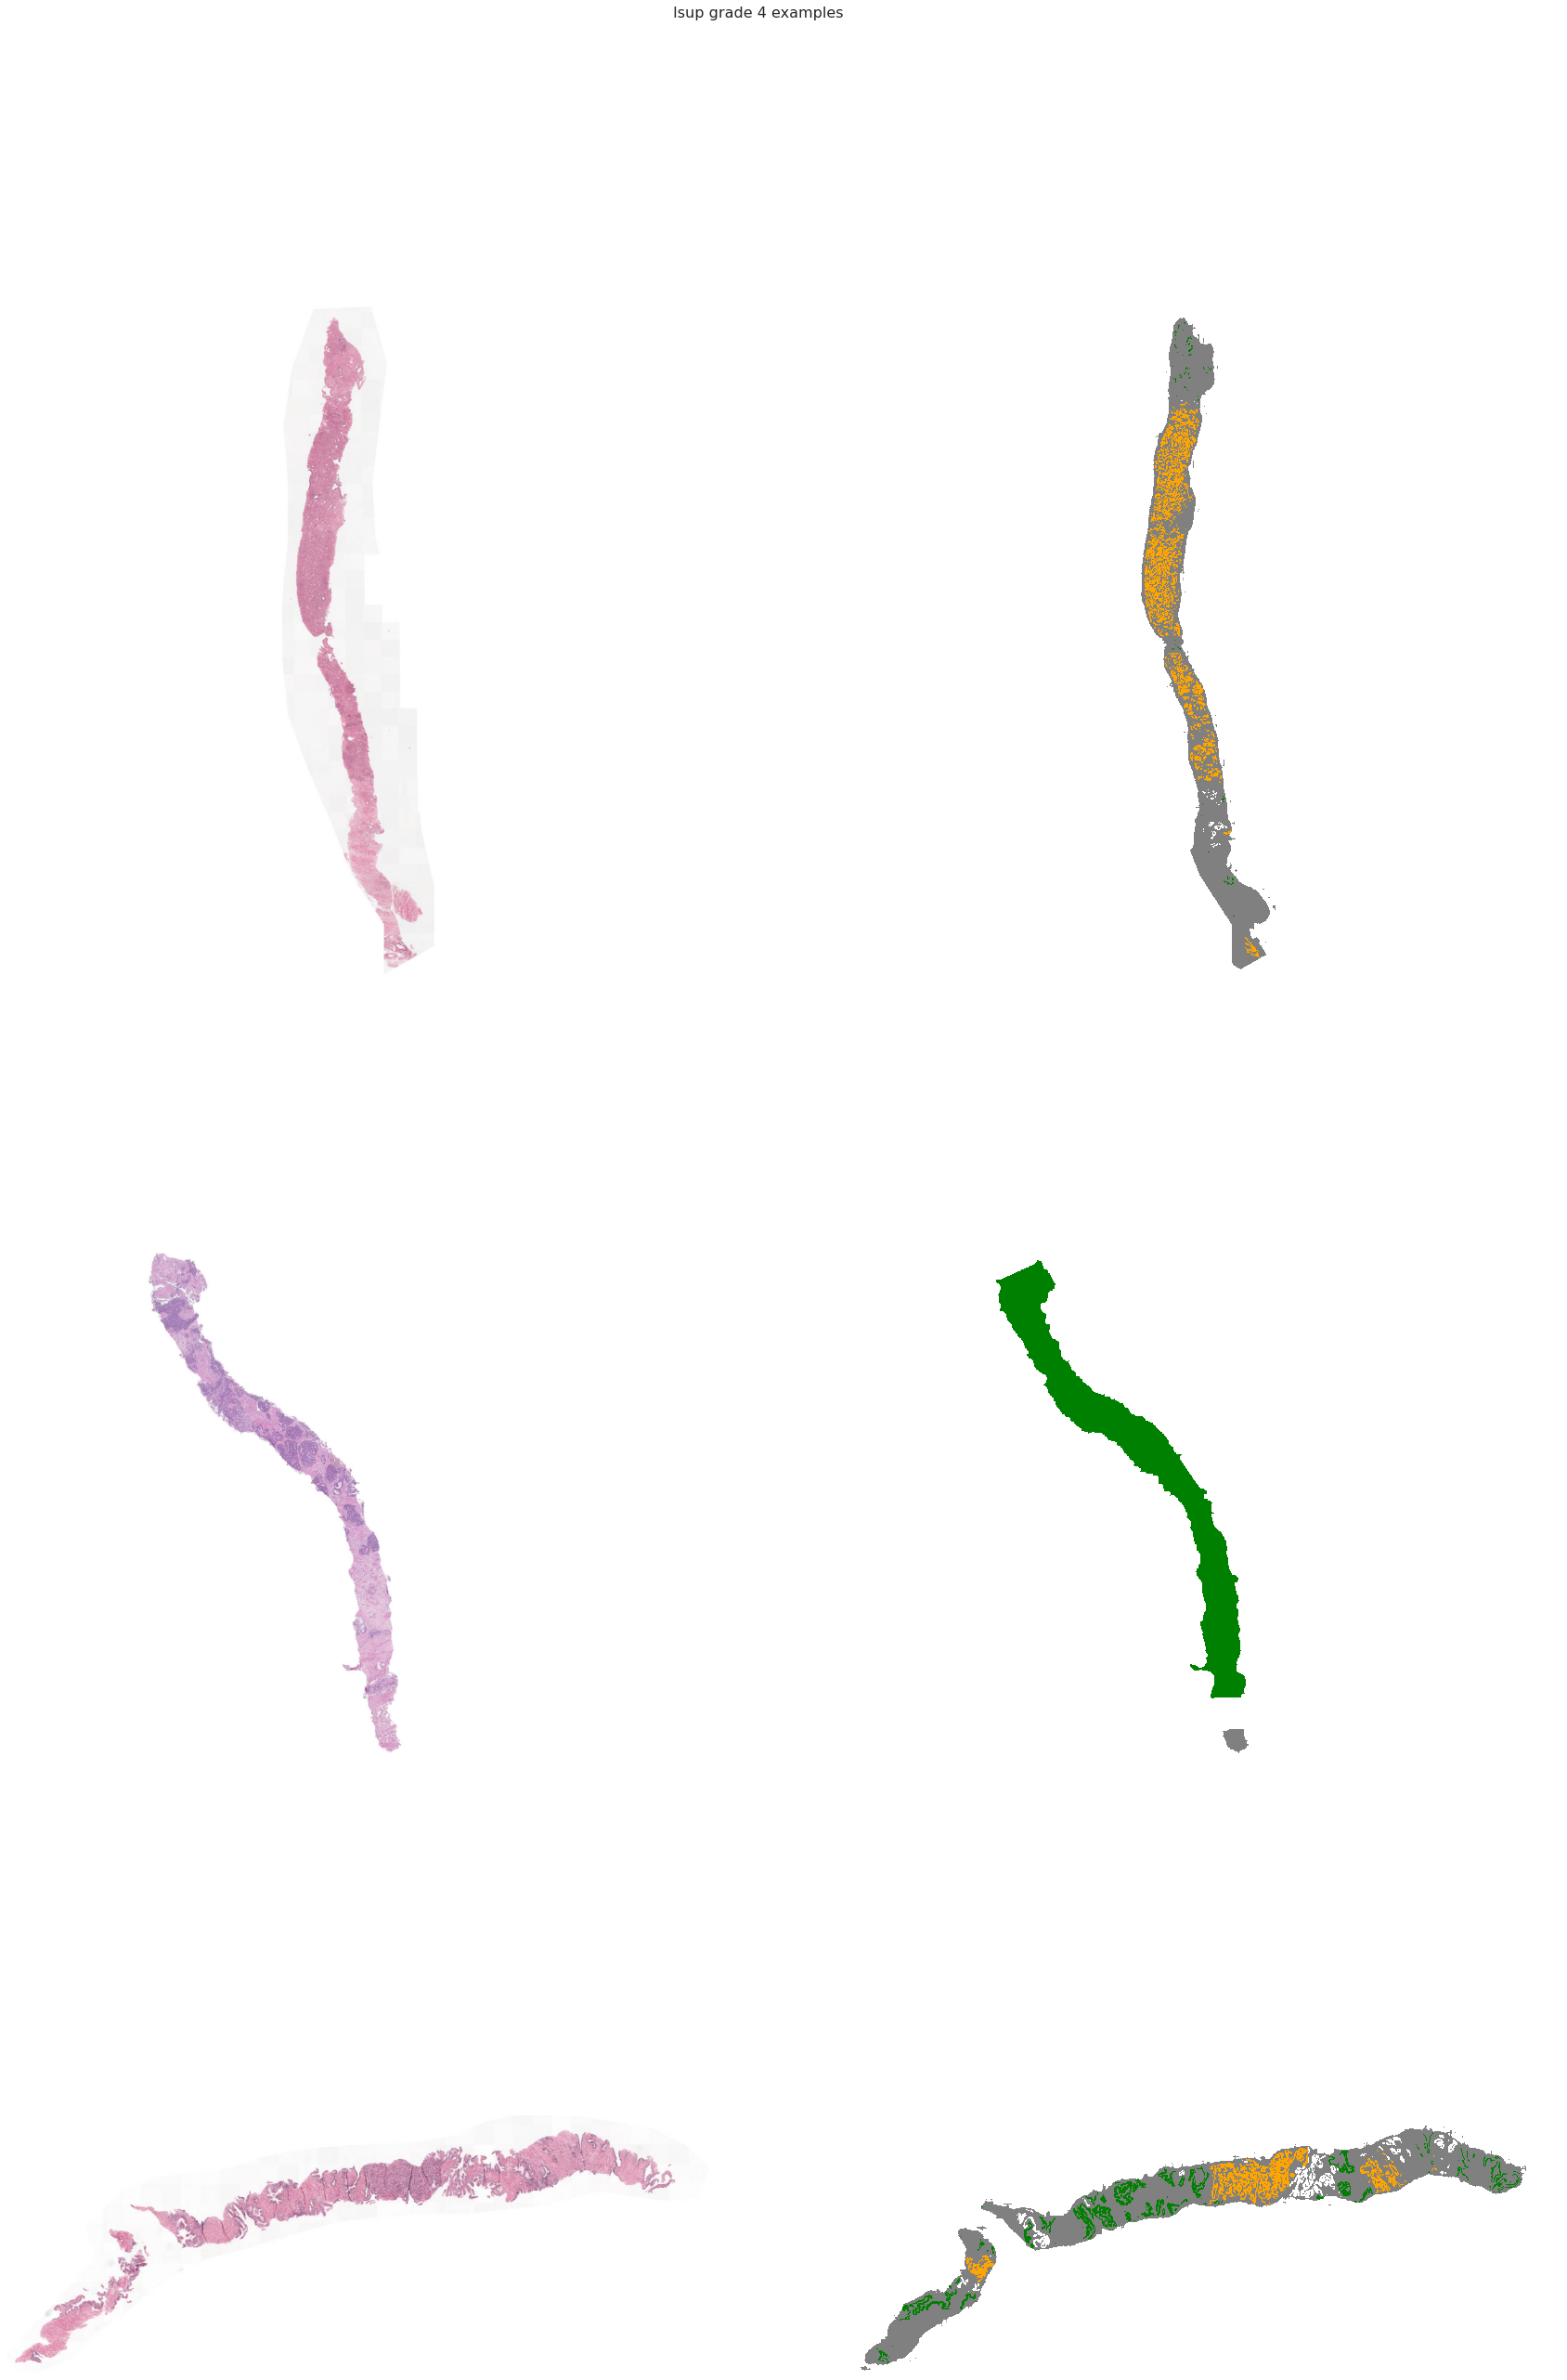

In [24]:
n = 3
isup_grade = 4
img_ids = list(train_df[train_df['isup_grade']==isup_grade]['image_id'])[:n]
imgs = [MultiImage(train_images_path+img_id+'.tiff')[-1] for img_id in img_ids]
masks = [MultiImage(train_masks_path+img_id+'_mask.tiff')[-1] for img_id in img_ids]
print_n_image(imgs,masks,n,f'Isup grade {isup_grade} examples')

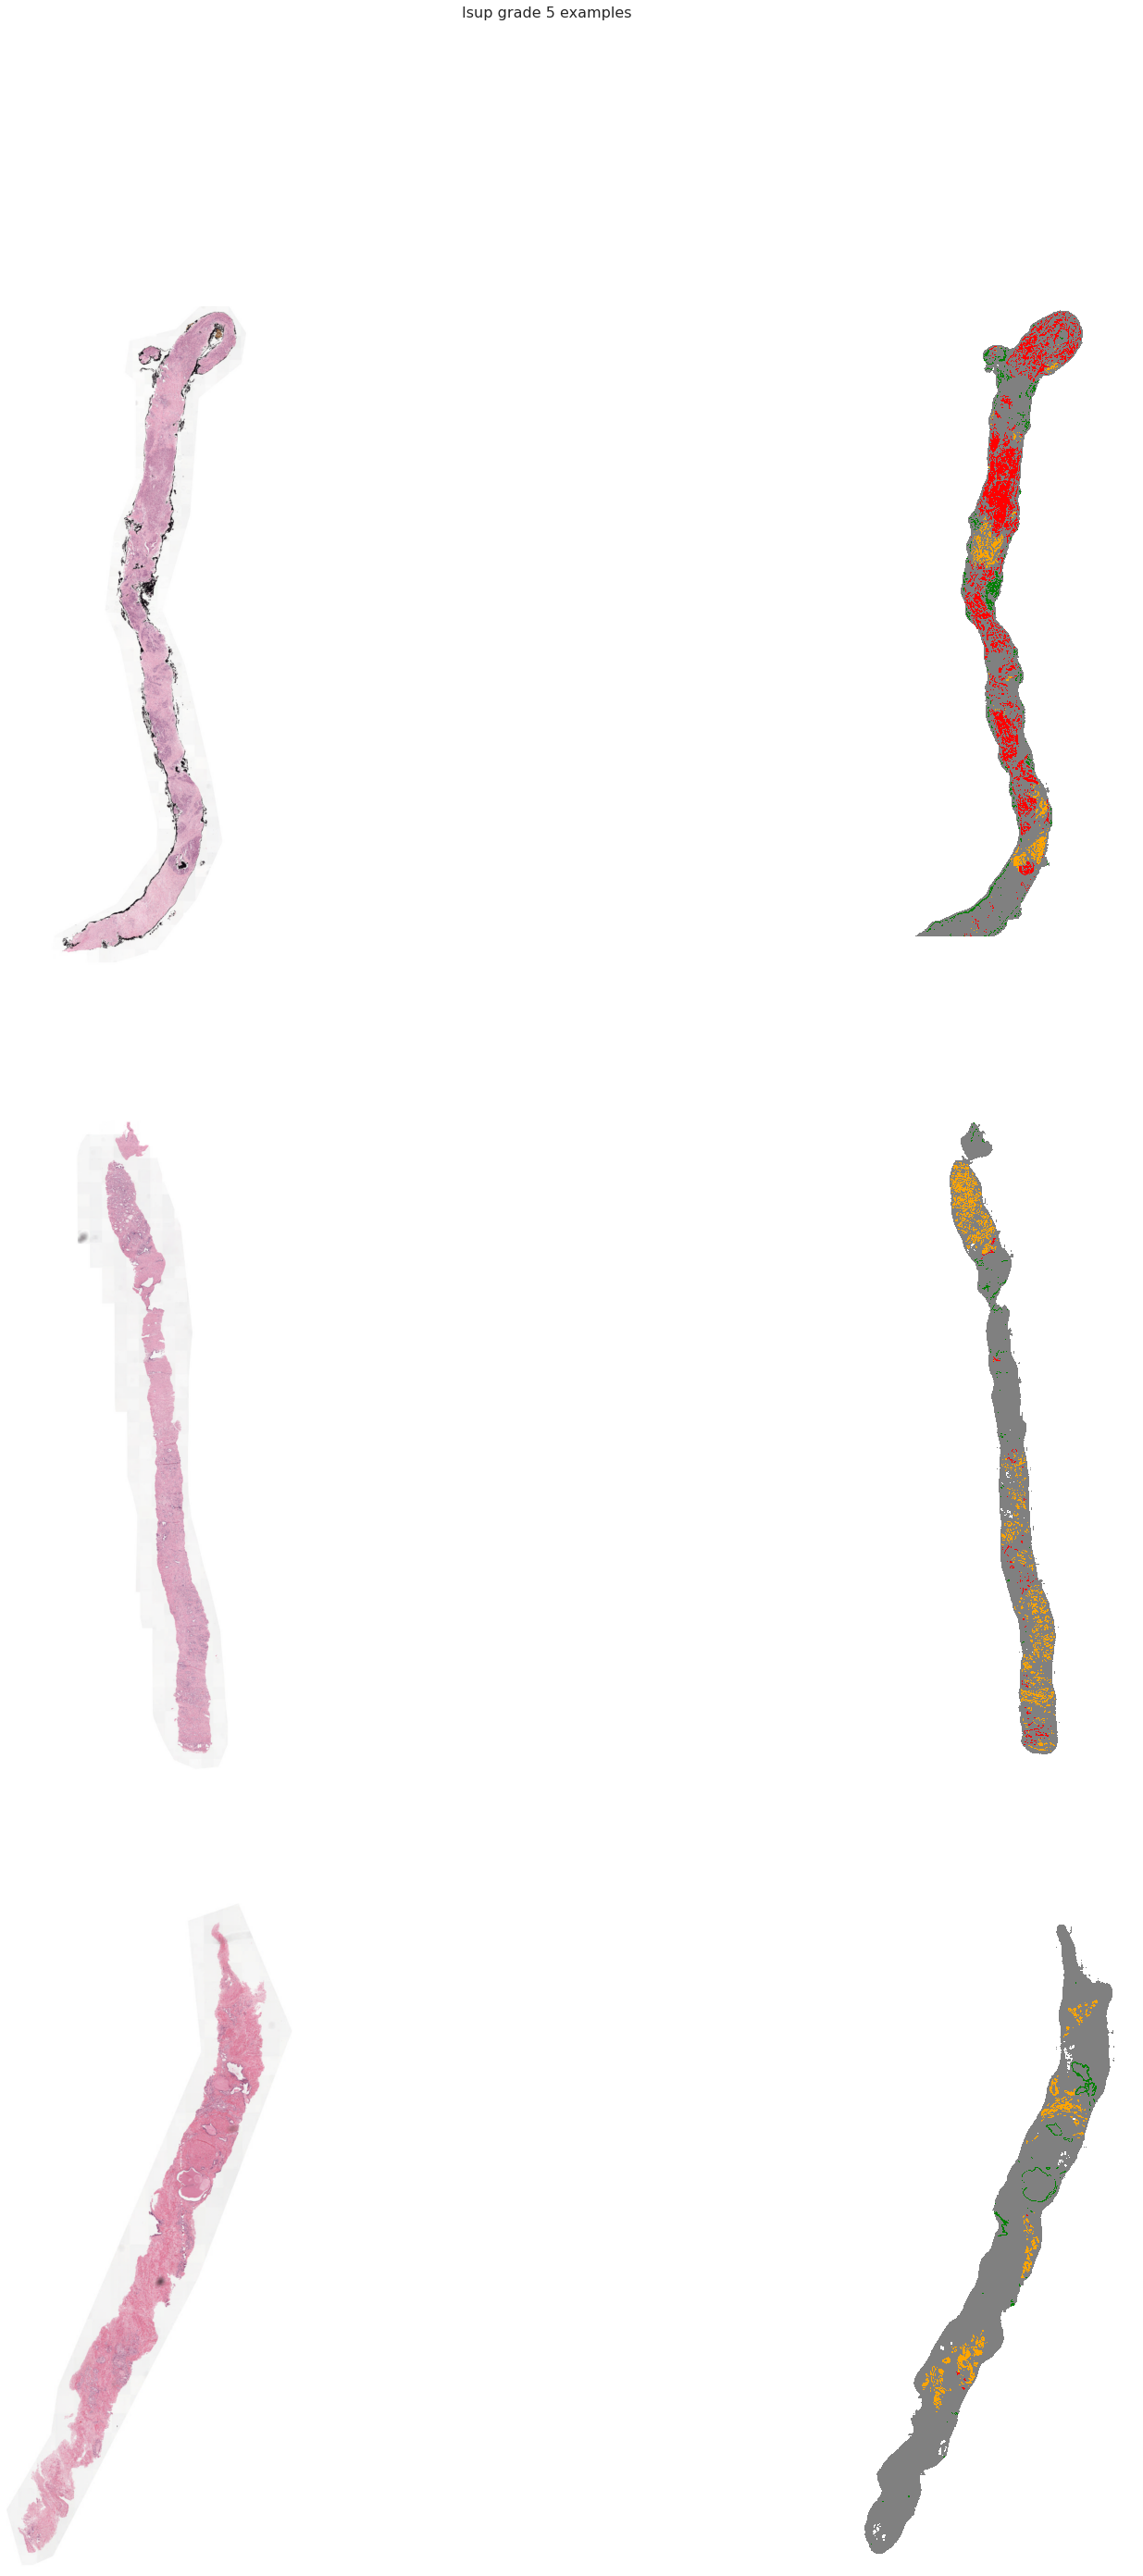

In [25]:
n = 3
isup_grade = 5
img_ids = list(train_df[train_df['isup_grade']==isup_grade]['image_id'])[:n]
imgs = [MultiImage(train_images_path+img_id+'.tiff')[-1] for img_id in img_ids]
masks = [MultiImage(train_masks_path+img_id+'_mask.tiff')[-1] for img_id in img_ids]
print_n_image(imgs,masks,n,f'Isup grade {isup_grade} examples')

In [26]:
class PANDA_Dataset(Dataset):
    '''
    this function takes dataframe and make transformations based on mode
    works also with masks incuded
    returns image and label
    '''
    def __init__(self,df,transform=None,mode='train',get_mask=False):
        self.df = df
        self.transform = transform
        self.mode = mode
        self.get_mask = get_mask
        if mode == 'test':
            self.path = test_images_path
            if not os.path.exists(self.path):
                self.path = train_images_path
        else:
            self.path = train_images_path

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        image_id = self.df['image_id'].loc[idx]
        
        img = MultiImage(self.path+image_id+'.tiff')[-1]
        if self.get_mask:
            mask = MultiImage(self.path+image_id+'_mask.tiff')[-1]
            image_s,mask_s = get_tissue_squares(img,mask)
            image,mask = concat_squares(image_s,mask_s)
            mask = mask[:,:,0]
        else:
            image_s = get_tissue_squares(img)
            image = concat_squares(image_s)
        
        # image = 255 - image
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image=image)['image']
            
        if self.mode != 'test':
            label = torch.tensor(self.df['isup_grade'].loc[idx]).float()
            if self.get_mask:
                return image,mask,label
            return image,label
            
        return image

In [27]:
png_path = '../input/image-preprocess/'

In [28]:
class PANDA_Dataset_png(Dataset):
    '''
    this function takes dataframe and make transformations based on mode
    works also with masks incuded
    returns image and label
    '''
    def __init__(self,df,transform=None,mode='train',get_mask=False):
        self.df = df
        self.transform = transform
        self.mode = mode
        self.get_mask = get_mask
        if mode == 'test':
            self.path = test_images_path
            if not os.path.exists(self.path):
                self.path = png_path
        else:
            self.path = png_path

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        image_id = self.df['image_id'].loc[idx]
        
        if self.mode == 'test':
            img = MultiImage(self.path+image_id+'.tiff')[-1]
            image_s = get_tissue_squares(img)
            image = concat_squares(image_s)
            # image = 255 - image
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        else:
            image = cv2.imread(self.path+image_id+'.png')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image=image)['image']
            
        if self.mode != 'test':
            label = torch.tensor(self.df['isup_grade'].loc[idx]).float()
            if self.get_mask:
                return image,mask,label
            return image,label
            
        return image

In [29]:
pd1 = PANDA_Dataset(train_df,None,'train')
pd2 = PANDA_Dataset_png(train_df,None,'train')

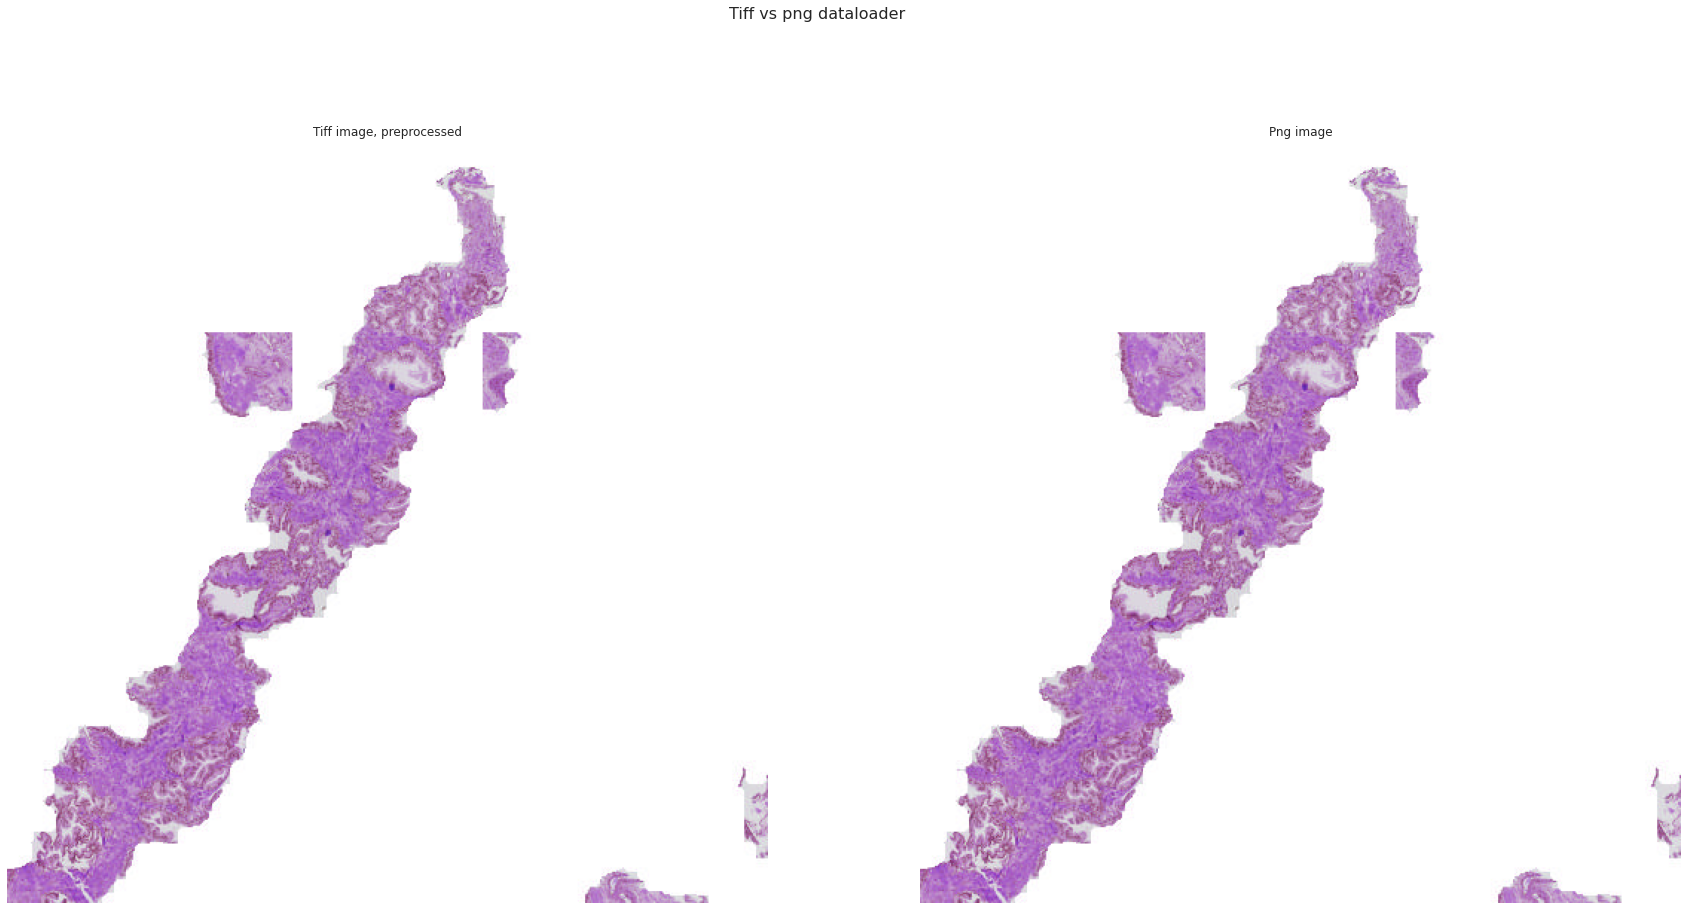

In [30]:
img1 = pd1.__getitem__(1)[0]
img2 = pd2.__getitem__(1)[0]
f,axs = plt.subplots(1,2,figsize=(30,15))
axs[0].imshow(img1)
axs[0].axis('off')
axs[0].set_title(f'Tiff image, preprocessed')
axs[1].imshow(img2)
axs[1].axis('off')
axs[1].set_title(f'Png image')
f.suptitle('Tiff vs png dataloader', fontsize=16)
plt.show()

In [31]:
def transform(mode,mean = [0.90010055, 0.80038306, 0.86555665],std = [0.13515256, 0.25455971, 0.16648444]):
    '''
    function that adds noise and normalizes images
    '''
    if mode == 'train':
        return Compose([
            VerticalFlip(),
            HorizontalFlip(),
            Normalize(mean=mean,std=std),
            ToTensorV2()])
    return Compose([
        Normalize(mean=mean,std=std),
        ToTensorV2()])

In [32]:
N_FOLD = 4
LR = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Model
SE-ResNext50

In [33]:
class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

In [34]:
class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out

In [35]:
class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride

In [36]:
class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x

In [37]:
def se_resnext50_32x4d(num_classes=1000):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    return model

In [38]:
class OurSeResNeXt50(nn.Module):
    def __init__(self,method='classification'):
        super(OurSeResNeXt50,self).__init__()
        
        self.model = se_resnext50_32x4d()
        #weights = torch.load(pretreined_model_path)
        #self.model.load_state_dict(weights)
        self.model.avg_pool = nn.AdaptiveAvgPool2d(1)
        in_features = self.model.last_linear.in_features
        
        if method == 'classification':
            self.model.last_linear = nn.Linear(in_features,6)
        elif method == 'regression': 
            self.model.last_linear = nn.Linear(in_features,1)
        else:
            print('Wrong method!')
            return
        
        
    def forward(self,x):
        x = self.model(x)
        return x

In [39]:
def training(dataset_='PANDA', model_='se-resnext50',method='classification',optimizer_type='ADAM'):
    '''
    this function takes dataset and performs training on given model
    returns predictions, labels
    '''
    preds_for_fold = []
    labels_for_fold = []
    
    if dataset_ == 'PANDA':
        dataset_function = PANDA_Dataset
    else:
        print('Dataset not implemented')
        return
        
    for fold in range(FOLDS):
        print(f'Fold {fold+1}')
        
        train_indexs = train_cp[train_cp['folds'] != fold].index        
        train_df = train_cp.loc[train_indexs].reset_index(drop=True)
        transform_train = transform('train')
        train_dataset = dataset_function(train_df,transform_train,'train',False)
        train_loader = DataLoader(train_dataset,16,shuffle=True, num_workers=4)
        
        valid_indexs = train_cp[train_cp['folds'] == fold].index
        valid_df = train_cp.loc[valid_indexs].reset_index(drop=True)
        transform_valid = transform('valid')
        valid_dataset = dataset_function(valid_df,transform_valid,'valid',False)
        valid_loader = DataLoader(valid_dataset,16,shuffle=False, num_workers=4)
        
        if model_ == 'se-resnext50':
            model = OurSeResNeXt50(method)
            model.to(device)
        else:
            print('Model not implemented')
            return
        
        if optimizer_type == 'ADAM':
            optimizer = Adam(model.parameters(), lr=LR, amsgrad=False)
        elif optimizer_type == 'SGD':
            optimizer = SGD(model.parameters(), lr=LR)
        else:
            print('Wrong optimizer')
            return
        
        scheduler = ReduceLROnPlateau(optimizer, factor=0.2, patience=3, verbose=True)
        
        if method == 'classification':
            criterion = nn.CrossEntropyLoss()
        elif method == 'regression': 
            criterion = nn.MSELoss()
        else:
            print('Wrong method!')
            return
           
        best_score = -100
        best_preds = None
        
        for epoch in range(EPOCHS):
            model.train()
            total_loss = 0
            
            optimizer.zero_grad()
            labels = []
            preds = []
            
            for i, (image,label) in tqdm(enumerate(train_loader),total=len(train_loader)):
                image = image.to(device)
                label = label.to(device)
                
                pred = model(image)
                
                preds.append(pred.to('cpu').detach().numpy())
                labels.append(label.to('cpu').detach().numpy())                
                
                loss = criterion(pred,label)
                loss.backward()
                total_loss += loss.item()
                optimizer.step()
                optimizer.zero_grad()
                
            total_loss /= len(train_loader)
            model.eval()
            
            total_valid_loss = 0
            valid_preds = []
            valid_labels = []
            for i, (image,label) in tqdm(enumerate(valid_loader),total=len(valid_loader)):
                image = image.to(device)
                label = label.to(device)
                
                with torch.no_grad():
                    pred = model(image)
                
                valid_preds.append(pred.to('cpu').numpy().argmax(1))
                valid_labels.append(label.to('cpu').numpy())
                
                loss = criterion(pred,label)
                total_valid_loss += loss.item()
            
            total_valid_loss /= len(valid_loader)
            
            scheduler.step(total_valid_loss)
            
            preds = np.concatenate(preds)
            labels = np.concatenate(labels)
            valid_preds = np.concatenate(valid_preds)
            valid_labels = np.concatenate(valid_labels)
            
            if method == 'regression':
                coefs = fit_coefs(preds,labels)
                coefs = coefs['x']
                K_score = kappa_score(coefs,valid_preds,valid_labels)
            elif method == 'classification':
                K_score = cohen_kappa_score(valid_labels, valid_preds, weights='quadratic')
            else:
                print('Wrong method!')
                return
            
            print(f'Epoch: {epoch}, Avg train loss: {total_loss}, Avg valid loss: {total_valid_loss}, Valid QWK: {K_score}')
            
            if K_score > best_score:
                best_score = K_score
                best_preds = valid_preds
                torch.save(model.state_dict(),f'SeResNeXt50-32x4d_classification_fold{fold}.pth')
                
        preds_for_fold.append(best_preds)
        labels_for_fold.append(valid_labels)
        
    preds_for_fold = np.concatenate(preds_for_fold)
    labels_for_fold = np.concatenate(labels_for_fold)
    
    return preds_for_fold,labels_for_fold

In [40]:
# preds,labels = training()

In [41]:
### REGRESSION
# coefs = fit_coefs(preds,labels)['x']
# kappa_score = kappa_score(coefs,preds,labels)
# print(f'Coefs: {coefs}')
# print(f'QWK: {kappa_score}')
# np.savetxt('coefs.csv', coefs, delimiter=',')

In [42]:
def submit(df):
    '''
    this function is for kaggle submition process
    '''
    transform_test = transform('test')
    test_dataset = PANDA_Dataset(df,transform_test,'test',False)
    test_loader = DataLoader(test_dataset,16,shuffle=False)
    
    final_preds = []
    for fold in range(N_FOLD):
        model = OurSeResNeXt50()
        model.to(device)
        weights = torch.load(f'../input/model-v1-3-fold{fold}/SeResNeXt50-32x4d_classification_fold{fold}.pth', map_location=device)
        model.load_state_dict(weights)
        test_preds = []
        for i, image in enumerate(test_loader):
            image = image.to(device)

            with torch.no_grad():
                pred = model(image)

            test_preds.append(pred.to('cpu').numpy())
        test_preds = np.concatenate(test_preds)
        final_preds.append(test_preds)
    final_preds = np.mean(final_preds,axis=0)
    
    ### CLASSIFICATION
    final_preds = final_preds.argmax(1)
    
    ### REGRESSION
    # final_preds = predict(coefs,final_preds)
    
    df['isup_grade'] = final_preds
    df['isup_grade'] = df['isup_grade'].astype(int)
    df.to_csv('submission.csv', index=False)

In [43]:
test_cp = test_df.copy().drop('data_provider',1)

In [44]:
train_cp = train_df.head(32).copy().drop('data_provider',1)

In [45]:
df = test_cp if os.path.exists(test_images_path) else train_cp

In [46]:
df.head()

image_id  isup_grade gleason_score
0  0005f7aaab2800f6170c399693a96917           0           0+0
1  000920ad0b612851f8e01bcc880d9b3d           0           0+0
2  0018ae58b01bdadc8e347995b69f99aa           4           4+4
3  001c62abd11fa4b57bf7a6c603a11bb9           4           4+4
4  001d865e65ef5d2579c190a0e0350d8f           0           0+0

In [47]:
# submit(df)